In [1]:
using ModelingToolkit, IntervalSets, Sophon, CairoMakie, Lux
using Optimization, OptimizationOptimJL

@parameters x,t
@variables θ(..), w(..)
Dₜ = Differential(t)
Dₜ² = Differential(t)^2
Dₓ = Differential(x)
Dₓ² = Differential(x)^2

g(x,t) = cos(t) - π/2 * sin(x)*cos(t)

eqs = [
    Dₜ²(θ(x,t)) - Dₓ²(θ(x,t)) + θ(x,t) - Dₓ(w(x,t)) ~ 0.0,
    Dₜ²(w(x,t)) - Dₓ²(w(x,t)) + Dₓ(θ(x,t)) ~ g(x,t)]

bcs = [
    θ(x, 0.0) ~ π/2*cos(x) + x - π/2,
    Dₜ(θ(x, 0.0)) ~ 0.0,
    w(x, 0.0) ~ π/2*sin(x),
    Dₜ(w(x, 0.0)) ~ 0.0,
    θ(0.0, t) ~ 0.0,
    θ(π, t) ~ 0.0,
    w(0.0, t) ~ 0.0, 
    w(π, t) ~ 0.0]

    
domains = [x ∈ Interval(0.0, π),
           t ∈ Interval(0.0, 1.0)]

@named timo = PDESystem(eqs, bcs, domains, [x,t], [θ(x,t),w(x,t)])

PDESystem
Equations: Equation[Differential(t)(Differential(t)(θ(x, t))) + θ(x, t) - Differential(x)(Differential(x)(θ(x, t))) - Differential(x)(w(x, t)) ~ 0.0, Differential(t)(Differential(t)(w(x, t))) + Differential(x)(θ(x, t)) - Differential(x)(Differential(x)(w(x, t))) ~ cos(t) - 1.5707963267948966cos(t)*sin(x)]
Boundary Conditions: Equation[θ(x, 0.0) ~ x + 1.5707963267948966cos(x) - 1.5707963267948966, Differential(t)(θ(x, 0.0)) ~ 0.0, w(x, 0.0) ~ 1.5707963267948966sin(x), Differential(t)(w(x, 0.0)) ~ 0.0, θ(0.0, t) ~ 0.0, θ(π, t) ~ 0.0, w(0.0, t) ~ 0.0, w(π, t) ~ 0.0]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(x, 0.0..3.141592653589793), Symbolics.VarDomainPairing(t, 0.0..1.0)]
Dependent Variables: Num[θ(x, t), w(x, t)]
Independent Variables: Num[x, t]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [2]:
pinn = PINN(θ = FullyConnected(2,1, tanh; hidden_dims=16,num_layers=3),
            w = FullyConnected(2,1, tanh; hidden_dims=16,num_layers=3))

sampler = QuasiRandomSampler(2000, 500)
strategy = NonAdaptiveTraining(1, 10)

prob = Sophon.discretize(timo, pinn, sampler, strategy)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(θ = (layer_1 = (weight = [0.30403825640678406 -0.831175684928894; 0.3405803442001343 -0.0861186683177948; … ; -0.44711992144584656 -1.3396133184432983; -1.3191970586776733 1.4017056226730347], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [-0.536034345626831 -0.34459495544433594 … -0.4213210344314575 0.13072244822978973; 0.5702672600746155 0.2847316563129425 … -0.278249591588974 0.4242517948150635; … ; 0.32148370146751404 0.48157623410224915 … 0.3147399127483368 0.035886138677597046; 0.4497758448123932 0.5848158001899719 … -0.04864802211523056 0.01179832685738802], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [-0.5881803035736084 0.39664098620414734 … -0.6376228332519531 0.6421265602111816; -0.4419313669204712 -0.5839046239852905 … -0.5412863492965698 0.6711235642433167; … ; -0.18566283583641052 -0.08467800170183182 … 0.4664505422115326 0.4950532913208008; -0.2960605025291443 -0.3632980287075043 … 0.2

In [3]:
function callback(p, l)
    #println("Loss: $l")
    return false
end

@time res = Optimization.solve(prob, BFGS(); maxiters=3000, callback=callback)

Loss: 73.02201733902484


Loss: 27.092355739911568


Loss: 17.33992535916274


Loss: 15.9947959262281


Loss: 13.52239571882196


Loss: 11.039642789523866


Loss: 9.324572162759669


Loss: 8.168624277631109


Loss: 7.48074027378245


Loss: 6.973908623366123


Loss: 6.4691305882394925


Loss: 5.898389578200716


Loss: 5.439004185836228


Loss: 5.085623531822889


Loss: 4.747569033603064


Loss: 4.354712947757961


Loss: 3.9162937627244645


Loss: 3.438802691193387


Loss: 3.1770222461596025


Loss: 2.605421986190146


Loss: 2.2667929293055336


Loss: 2.054915918522381


Loss: 1.9348615406277638


Loss: 1.8233342401033288


Loss: 1.5838197018735871


Loss: 1.448085683931987


Loss: 1.320869053152532


Loss: 1.174026556780913


Loss: 1.0578264801638273


Loss: 0.9005511263073962


Loss: 0.849450408350887


Loss: 0.7928388859381967


Loss: 0.749616215096482


Loss: 0.7174273264002008


Loss: 0.6771234362528997


Loss: 0.6194905690269338


Loss: 0.5691897914443552


Loss: 0.5325157443515448


Loss: 0.5049341397499989


Loss: 0.47917249937194906


Loss: 0.4572324600003714


Loss: 0.4396410587452726


Loss: 0.4243318073355473


Loss: 0.41712374036369243


Loss: 0.4087244363114456


Loss: 0.383925682371737


Loss: 0.3796673899046849


Loss: 0.3569894751777088


Loss: 0.3300696820100856


Loss: 0.312588034016992


Loss: 0.3083788401724776


Loss: 0.3011100807721529


Loss: 0.26942200422512735


Loss: 0.26384604219995894


Loss: 0.24488284536229435


Loss: 0.23884438448288978


Loss: 0.20991731402028183


Loss: 0.20633759309828295


Loss: 0.19464794211477812


Loss: 0.18904021047785396


Loss: 0.17057484244341625


Loss: 0.16573361645887807


Loss: 0.15690575125056005


Loss: 0.12137541803602361


Loss: 0.1177130510396458


Loss: 0.11150431598563224


Loss: 0.10517175711882676


Loss: 0.09775288299656888


Loss: 0.08094188700012801


Loss: 0.07747140544828422


Loss: 0.07325881883781414


Loss: 0.06947505048835022


Loss: 0.06643982932038495


Loss: 0.054980364249345375


Loss: 0.052795505537039815


Loss: 0.04813048412769105


Loss: 0.04168131317149674


Loss: 0.03726027583569996


Loss: 0.034776148599643196


Loss: 0.032397519406642476


Loss: 0.028369714427927094


Loss: 0.026382363434103488


Loss: 0.021837330146063625


Loss: 0.020217124951274743


Loss: 0.018177753995787926


Loss: 0.016386278913964013


Loss: 0.014503604412349335


Loss: 0.012889309364803933


Loss: 0.011640104291659065


Loss: 0.010706707959014058


Loss: 0.0095723090535736


Loss: 0.00854820825228721


Loss: 0.008008886508033494


Loss: 0.007011091656688048


Loss: 0.006300323710354138


Loss: 0.00585207296921426


Loss: 0.005268233227817954


Loss: 0.004665351936421849


Loss: 0.004023990777192671


Loss: 0.0037513376535686397


Loss: 0.003458479890738273


Loss: 0.0031536251891866813


Loss: 0.003013371139246121


Loss: 0.0028535176986426492


Loss: 0.002712861650427651


Loss: 0.002578934169674203


Loss: 0.002445922309952035


Loss: 0.002283559262533399


Loss: 0.002171099793021713


Loss: 0.0020730942442251546


Loss: 0.0019623979160447143


Loss: 0.0018570180012301909


Loss: 0.0017596722137165537


Loss: 0.0016638928712311154


Loss: 0.0015816519802886128


Loss: 0.0014798041548708203


Loss: 0.0014036004892304796


Loss: 0.0013332181481429037


Loss: 0.0012769438461063547


Loss: 0.0012046758664875287


Loss: 0.0011587233291488971


Loss: 0.0011078184877364237


Loss: 0.0010648347805789103


Loss: 0.0010236598103142338


Loss: 0.0009766421457674196


Loss: 0.0009467701853603315


Loss: 0.0009163078173223857


Loss: 0.0008854533378719713


Loss: 0.0008554481030950211


Loss: 0.0008305432263968409


Loss: 0.0007870419936778707


Loss: 0.000760929411257922


Loss: 0.0007337314560985134


Loss: 0.0007056104599444763


Loss: 0.0006813044404972327


Loss: 0.0006545834638938626


Loss: 0.0006318322132371875


Loss: 0.0006118719240030325


Loss: 0.0005928804866630068


Loss: 0.0005802123161573063


Loss: 0.0005602820600494266


Loss: 0.0005426940250482101


Loss: 0.0005267933266318107


Loss: 0.0005110763964194217


Loss: 0.0004957878276962856


Loss: 0.0004727860856024843


Loss: 0.0004558143246006547


Loss: 0.0004344545497639129


Loss: 0.0004171489967524158


Loss: 0.00040557679230418113


Loss: 0.0003929431306360352


Loss: 0.0003838860056220049


Loss: 0.00037407335293481836


Loss: 0.0003650159079642554


Loss: 0.00035458762984610627


Loss: 0.00034480396114016856


Loss: 0.0003365324753184666


Loss: 0.0003292218155465473


Loss: 0.0003212117482196893


Loss: 0.0003131464506086278


Loss: 0.0003036417615244802


Loss: 0.00029697208539895527


Loss: 0.0002916021249991461


Loss: 0.0002852507515053936


Loss: 0.00028119185056905976


Loss: 0.00027516085024742036


Loss: 0.00026849578983537527


Loss: 0.0002611409420854038


Loss: 0.0002560708736524417


Loss: 0.0002514683049998322


Loss: 0.00024822188600480925


Loss: 0.000242948692241079


Loss: 0.00023682134934897815


Loss: 0.0002303397848112678


Loss: 0.00022589336186541764


Loss: 0.00022220889172530256


Loss: 0.00021866777160141774


Loss: 0.0002151788994068146


Loss: 0.00021098055715913566


Loss: 0.000205405520976432


Loss: 0.0002000755999691561


Loss: 0.00019398425465377256


Loss: 0.00018779837476504341


Loss: 0.0001832703803761942


Loss: 0.00017813906339616032


Loss: 0.0001749258281410271


Loss: 0.00017025868557286284


Loss: 0.00016576713330994675


Loss: 0.00016280424744466242


Loss: 0.0001599178747490429


Loss: 0.00015700172085347444


Loss: 0.00015374875083576484


Loss: 0.00015046218490383313


Loss: 0.00014648865704757036


Loss: 0.00014250180108433345


Loss: 0.00013898032048811112


Loss: 0.0001363796908196806


Loss: 0.00013290511683784935


Loss: 0.00012989396271306558


Loss: 0.00012617327850406447


Loss: 0.00012340226402308163


Loss: 0.00011994161008461432


Loss: 0.00011788247952537432


Loss: 0.00011563091351708277


Loss: 0.00011391526234236811


Loss: 0.00011248744629223533


Loss: 0.00011111778052069224


Loss: 0.00010920859770639051


Loss: 0.00010750619313787632


Loss: 0.00010569635729226149


Loss: 0.00010333985350467291


Loss: 0.00010140723467237878


Loss: 9.981204132637842e-5


Loss: 9.825422443056639e-5


Loss: 9.649028633580056e-5


Loss: 9.484154149185682e-5


Loss: 9.298684869445051e-5


Loss: 9.071056725973786e-5


Loss: 8.916452686330456e-5


Loss: 8.726826254085497e-5


Loss: 8.585112704885362e-5


Loss: 8.484199096172084e-5


Loss: 8.389730115540586e-5


Loss: 8.310136687266741e-5


Loss: 8.219620666564418e-5


Loss: 8.129879145893164e-5


Loss: 8.03881122067739e-5


Loss: 7.887549729714452e-5


Loss: 7.744758815269872e-5


Loss: 7.609592655554551e-5


Loss: 7.477680446000712e-5


Loss: 7.383850165729466e-5


Loss: 7.320916598877337e-5


Loss: 7.243959488400816e-5


Loss: 7.144418416724714e-5


Loss: 7.038350863505495e-5


Loss: 6.958755390648923e-5


Loss: 6.864677959134022e-5


Loss: 6.774905463065946e-5


Loss: 6.713416576013261e-5


Loss: 6.660164563017628e-5


Loss: 6.591291032280736e-5


Loss: 6.504473892612672e-5


Loss: 6.406902222854355e-5


Loss: 6.317330558171805e-5


Loss: 6.207198496448169e-5


Loss: 6.0939171789437304e-5


Loss: 5.994087839271704e-5


Loss: 5.8830422693849124e-5


Loss: 5.7852697931051895e-5


Loss: 5.690481025071023e-5


Loss: 5.558938737096306e-5


Loss: 5.437152790735848e-5


Loss: 5.304935394452694e-5


Loss: 5.20258326985248e-5


Loss: 5.120677937436873e-5


Loss: 5.0013517037951614e-5


Loss: 4.902926964147496e-5


Loss: 4.819472494787708e-5


Loss: 4.753163629057547e-5


Loss: 4.6986420795811255e-5


Loss: 4.642572455508995e-5


Loss: 4.5880071189818886e-5


Loss: 4.5373503951162384e-5


Loss: 4.480796207099022e-5


Loss: 4.424881612975086e-5


Loss: 4.3845037213419484e-5


Loss: 4.3320060184739976e-5


Loss: 4.282784464066394e-5


Loss: 4.228206386027012e-5


Loss: 4.133712941754784e-5


Loss: 4.036770674112184e-5


Loss: 3.968221056362527e-5


Loss: 3.909708432032765e-5


Loss: 3.857429424766943e-5


Loss: 3.8130990514378725e-5


Loss: 3.7627982776478386e-5


Loss: 3.692220920634772e-5


Loss: 3.6353341637722976e-5


Loss: 3.574746562778287e-5


Loss: 3.516555712418776e-5


Loss: 3.453982905590874e-5


Loss: 3.388900098792444e-5


Loss: 3.322013623689906e-5


Loss: 3.2852338420353335e-5


Loss: 3.256064863677153e-5


Loss: 3.2343530131675115e-5


Loss: 3.2059221204838144e-5


Loss: 3.1628847764553e-5


Loss: 3.1243617928057354e-5


Loss: 3.087604273171808e-5


Loss: 3.037007779034964e-5


Loss: 2.9843816983407628e-5


Loss: 2.9302729279766616e-5


Loss: 2.8851944377364136e-5


Loss: 2.851432694690103e-5


Loss: 2.8135667397148106e-5


Loss: 2.786948064406225e-5


Loss: 2.7490450178254838e-5


Loss: 2.7136920110535153e-5


Loss: 2.690013179076323e-5


Loss: 2.6754446702854602e-5


Loss: 2.6521100770012918e-5


Loss: 2.6335349224340802e-5


Loss: 2.619565217330728e-5


Loss: 2.604035496534822e-5


Loss: 2.5878282960025902e-5


Loss: 2.5732051019840666e-5


Loss: 2.558714015138101e-5


Loss: 2.5413933277849237e-5


Loss: 2.5192593797961033e-5


Loss: 2.490155397684635e-5


Loss: 2.432851296492815e-5


Loss: 2.3926729377168405e-5


Loss: 2.3657298544550088e-5


Loss: 2.345437034872464e-5


Loss: 2.3270488320761322e-5


Loss: 2.2979563117919554e-5


Loss: 2.2565191104092845e-5


Loss: 2.218458196516627e-5


Loss: 2.190710826090219e-5


Loss: 2.166116924961316e-5


Loss: 2.150071774252298e-5


Loss: 2.1381642791043124e-5


Loss: 2.1231744008752512e-5


Loss: 2.1059723614858042e-5


Loss: 2.080311460022858e-5


Loss: 2.0496562615487803e-5


Loss: 2.0255925041164905e-5


Loss: 1.992334990860285e-5


Loss: 1.9602616808756285e-5


Loss: 1.9355500994020768e-5


Loss: 1.9079419521060792e-5


Loss: 1.878602501728182e-5


Loss: 1.8526414172763084e-5


Loss: 1.8312416622625295e-5


Loss: 1.807631998107047e-5


Loss: 1.7741072822788427e-5


Loss: 1.748514424250987e-5


Loss: 1.7259789903959016e-5


Loss: 1.7076098687298544e-5


Loss: 1.6704660696338207e-5


Loss: 1.6387788170228265e-5


Loss: 1.6188600172652795e-5


Loss: 1.596045518820655e-5


Loss: 1.5807211995278946e-5


Loss: 1.5640857463821693e-5


Loss: 1.5473377391041664e-5


Loss: 1.5322697959385173e-5


Loss: 1.5154181872280402e-5


Loss: 1.501102086425413e-5


Loss: 1.4896883690910983e-5


Loss: 1.4719592163716393e-5


Loss: 1.4548281120467163e-5


Loss: 1.4386092271258028e-5


Loss: 1.4199024541311063e-5


Loss: 1.4004853482411667e-5


Loss: 1.3870901719403506e-5


Loss: 1.3796772390840328e-5


Loss: 1.3751899416206234e-5


Loss: 1.3693490496881524e-5


Loss: 1.3626908611194452e-5


Loss: 1.3508260906310047e-5


Loss: 1.33541304967892e-5


Loss: 1.3217664998071797e-5


Loss: 1.3104067107238891e-5


Loss: 1.2907532032031099e-5


Loss: 1.273012986396166e-5


Loss: 1.2529805000178546e-5


Loss: 1.238345827822144e-5


Loss: 1.2249995427514624e-5


Loss: 1.2159365088311911e-5


Loss: 1.2077813299448133e-5


Loss: 1.199400675082336e-5


Loss: 1.1924905709664024e-5


Loss: 1.1875567097325178e-5


Loss: 1.1825604989810415e-5


Loss: 1.1771000503162891e-5


Loss: 1.1705350264051145e-5


Loss: 1.1631883015893177e-5


Loss: 1.1552986650241707e-5


Loss: 1.1456233813234717e-5


Loss: 1.1338813755887214e-5


Loss: 1.1230428056366992e-5


Loss: 1.1087854062450011e-5


Loss: 1.0967182585236617e-5


Loss: 1.0843679870252546e-5


Loss: 1.0752164494558662e-5


Loss: 1.0672862807894116e-5


Loss: 1.0591719389859251e-5


Loss: 1.0506576811233435e-5


Loss: 1.040414961666091e-5


Loss: 1.0305938042376878e-5


Loss: 1.0225393998958643e-5


Loss: 1.0139854544869525e-5


Loss: 1.0040194474994997e-5


Loss: 9.953498382409477e-6


Loss: 9.874843120040081e-6


Loss: 9.804317976531004e-6


Loss: 9.725118552969382e-6


Loss: 9.655720578412299e-6


Loss: 9.58208968058834e-6


Loss: 9.52990713195408e-6


Loss: 9.481814076968808e-6


Loss: 9.415511502904774e-6


Loss: 9.352261928688367e-6


Loss: 9.271493520057569e-6


Loss: 9.185467401602408e-6


Loss: 9.126588428770885e-6


Loss: 9.075257839712299e-6


Loss: 9.004647400186896e-6


Loss: 8.911272709027449e-6


Loss: 8.791739304282716e-6


Loss: 8.687153046062687e-6


Loss: 8.57788652048902e-6


Loss: 8.481948925794676e-6


Loss: 8.4230837888882e-6


Loss: 8.365236605138651e-6


Loss: 8.299928259257322e-6


Loss: 8.240776632965228e-6


Loss: 8.181106808024436e-6


Loss: 8.11094421655706e-6


Loss: 8.010098516937127e-6


Loss: 7.870485636876254e-6


Loss: 7.738921836083538e-6


Loss: 7.622047518774259e-6


Loss: 7.5338016232507804e-6


Loss: 7.444105020081939e-6


Loss: 7.380837431809113e-6


Loss: 7.314082803419257e-6


Loss: 7.261252938836115e-6


Loss: 7.227225109874185e-6


Loss: 7.19407722393038e-6


Loss: 7.1650376432921504e-6


Loss: 7.129880853633631e-6


Loss: 7.0861780226098435e-6


Loss: 7.0276032953621185e-6


Loss: 6.982403297751655e-6


Loss: 6.934026025197314e-6


Loss: 6.897490702064613e-6


Loss: 6.8566784199109235e-6


Loss: 6.811895191818151e-6


Loss: 6.770258684306842e-6


Loss: 6.738892506470851e-6


Loss: 6.706938627256186e-6


Loss: 6.663309968332632e-6


Loss: 6.631047495173089e-6


Loss: 6.602236611718417e-6


Loss: 6.563530676657338e-6


Loss: 6.529518820769596e-6


Loss: 6.4847428076127545e-6


Loss: 6.420391871303708e-6


Loss: 6.367308217926361e-6


Loss: 6.314631179674275e-6


Loss: 6.260360797851659e-6


Loss: 6.176467018241172e-6


Loss: 6.081169445684356e-6


Loss: 5.987589375292408e-6


Loss: 5.906724734549027e-6


Loss: 5.845337766307244e-6


Loss: 5.8040756656636615e-6


Loss: 5.784396847874291e-6


Loss: 5.767995254331441e-6


Loss: 5.744215856612645e-6


Loss: 5.717753853188861e-6


Loss: 5.679167669471754e-6


Loss: 5.633747708632982e-6


Loss: 5.566790912996903e-6


Loss: 5.465648741220938e-6


Loss: 5.382607357945917e-6


Loss: 5.349869615550141e-6


Loss: 5.321332691417185e-6


Loss: 5.298636088932133e-6


Loss: 5.28097610884222e-6


Loss: 5.264618398037734e-6


Loss: 5.243164938482255e-6


Loss: 5.212656981189951e-6


Loss: 5.1565252566392064e-6


Loss: 5.084385048933533e-6


Loss: 5.04442290543128e-6


Loss: 5.000269467495646e-6


Loss: 4.96956468425025e-6


Loss: 4.949097855845348e-6


Loss: 4.928572413673573e-6


Loss: 4.89319827310153e-6


Loss: 4.8378311438273255e-6


Loss: 4.756035270685317e-6


Loss: 4.672651066521302e-6


Loss: 4.60017355627691e-6


Loss: 4.552646400307839e-6


Loss: 4.523468013711262e-6


Loss: 4.49951625836902e-6


Loss: 4.470787573623217e-6


Loss: 4.429045376962604e-6


Loss: 4.394052068235851e-6


Loss: 4.364274545735706e-6


Loss: 4.319390551480027e-6


Loss: 4.278276285265676e-6


Loss: 4.247894096936876e-6


Loss: 4.227272873052334e-6


Loss: 4.208551751413582e-6


Loss: 4.195895640246617e-6


Loss: 4.1853160232205705e-6


Loss: 4.170870019833195e-6


Loss: 4.1536389973033964e-6


Loss: 4.129633697859228e-6


Loss: 4.101428460009805e-6


Loss: 4.049370936014569e-6


Loss: 3.969093565647604e-6


Loss: 3.889815973977132e-6


Loss: 3.83827933368671e-6


Loss: 3.799365583737431e-6


Loss: 3.776331856736409e-6


Loss: 3.7552863473783688e-6


Loss: 3.732202530816076e-6


Loss: 3.7172481736260276e-6


Loss: 3.707020006904774e-6


Loss: 3.6989206075357943e-6


Loss: 3.688779147401998e-6


Loss: 3.67488338037517e-6


Loss: 3.6625373547144027e-6


Loss: 3.645654184377931e-6


Loss: 3.609703675133227e-6


Loss: 3.564892226810902e-6


Loss: 3.524027125643729e-6


Loss: 3.489454915924525e-6


Loss: 3.460738844291685e-6


Loss: 3.4332872030156935e-6


Loss: 3.4023611211899816e-6


Loss: 3.3675343884170517e-6


Loss: 3.3395017411118404e-6


Loss: 3.315908190416888e-6


Loss: 3.3019721785906793e-6


Loss: 3.2895909691249005e-6


Loss: 3.2790000417297006e-6


Loss: 3.2667185691666096e-6


Loss: 3.2456569066698627e-6


Loss: 3.2137333871744917e-6


Loss: 3.1627803152006776e-6


Loss: 3.108544330708115e-6


Loss: 3.0565397210570924e-6


Loss: 3.0403300647069643e-6


Loss: 3.025237728851414e-6


Loss: 3.012968548261944e-6


Loss: 2.9910453210429766e-6


Loss: 2.970365385854931e-6


Loss: 2.949066408940939e-6


Loss: 2.9326915283122118e-6


Loss: 2.9170030200438773e-6


Loss: 2.9041503649035686e-6


Loss: 2.894666409640422e-6


Loss: 2.8858991913878715e-6


Loss: 2.8746081587626864e-6


Loss: 2.864758604427092e-6


Loss: 2.8544477225285895e-6


Loss: 2.8449843974730123e-6


Loss: 2.833148005384917e-6


Loss: 2.813223756159697e-6


Loss: 2.7921233330695767e-6


Loss: 2.7721607504106247e-6


Loss: 2.7488019057803125e-6


Loss: 2.7260600855166642e-6


Loss: 2.7082383188204637e-6


Loss: 2.688099013296417e-6


Loss: 2.6707316660184767e-6


Loss: 2.649906227290455e-6


Loss: 2.627763155058702e-6


Loss: 2.6005801424834113e-6


Loss: 2.578840787008848e-6


Loss: 2.5636002112744716e-6


Loss: 2.5394503480863007e-6


Loss: 2.520209572702429e-6


Loss: 2.5023176051792016e-6


Loss: 2.488952897007668e-6


Loss: 2.48133718488549e-6


Loss: 2.475730297136551e-6


Loss: 2.471537715866139e-6


Loss: 2.4636064130160084e-6


Loss: 2.455744892608053e-6


Loss: 2.4486777833732763e-6


Loss: 2.4418988596419973e-6


Loss: 2.4323401956348955e-6


Loss: 2.4224297785106365e-6


Loss: 2.411902810234467e-6


Loss: 2.3972395658693166e-6


Loss: 2.376994334986309e-6


Loss: 2.354695301680511e-6


Loss: 2.3413632183744016e-6


Loss: 2.3250301127373584e-6


Loss: 2.314939100680872e-6


Loss: 2.3086204794461565e-6


Loss: 2.3040879495060436e-6


Loss: 2.299390801305417e-6


Loss: 2.293909940320398e-6


Loss: 2.286732314227385e-6


Loss: 2.2763583355488935e-6


Loss: 2.266095809127105e-6


Loss: 2.2582665007444192e-6


Loss: 2.2516654467366097e-6


Loss: 2.245554207520627e-6


Loss: 2.23918188300615e-6


Loss: 2.2331306535702844e-6


Loss: 2.2271852924663434e-6


Loss: 2.2199725209325445e-6


Loss: 2.211658012819815e-6


Loss: 2.2004019126480085e-6


Loss: 2.187408465861457e-6


Loss: 2.1727252797026234e-6


Loss: 2.1567807394507684e-6


Loss: 2.141347222788998e-6


Loss: 2.1247193119637507e-6


Loss: 2.0956448596696593e-6


Loss: 2.063018764288699e-6


Loss: 2.048236914833934e-6


Loss: 2.029537388660995e-6


Loss: 2.0149966531400575e-6


Loss: 2.0044733062748825e-6


Loss: 1.998301932720227e-6


Loss: 1.9925727953045925e-6


Loss: 1.988860475753368e-6


Loss: 1.98615493682185e-6


Loss: 1.982740926071489e-6


Loss: 1.9793206734765807e-6


Loss: 1.976178607070236e-6


Loss: 1.973073854219011e-6


Loss: 1.970298578122304e-6


Loss: 1.967890613559159e-6


Loss: 1.9654912223187213e-6


Loss: 1.9623896174234034e-6


Loss: 1.9554693578969845e-6


Loss: 1.9470154087350854e-6


Loss: 1.9358954692599992e-6


Loss: 1.9276506967855494e-6


Loss: 1.9161338122163394e-6


Loss: 1.9040237769032617e-6


Loss: 1.891475379842489e-6


Loss: 1.877889166507667e-6


Loss: 1.8682001229697892e-6


Loss: 1.8555839694556546e-6


Loss: 1.8456636417409521e-6


Loss: 1.8382400342008239e-6


Loss: 1.829454955055902e-6


Loss: 1.8231700223331028e-6


Loss: 1.8190568087749639e-6


Loss: 1.8160805168658338e-6


Loss: 1.814083531510842e-6


Loss: 1.8118604372901053e-6


Loss: 1.8092698383941967e-6


Loss: 1.8064622442281213e-6


Loss: 1.8035049215213097e-6


Loss: 1.8005613303207016e-6


Loss: 1.7976497843386126e-6


Loss: 1.7932467902969343e-6


Loss: 1.7855253494700625e-6


Loss: 1.7755672728072682e-6


Loss: 1.763032725016385e-6


Loss: 1.7503531436891032e-6


Loss: 1.7386664670560187e-6


Loss: 1.7296788922851621e-6


Loss: 1.7232766962689586e-6


Loss: 1.7162127344516693e-6


Loss: 1.7071888119264932e-6


Loss: 1.6974241671786712e-6


Loss: 1.6889659661366224e-6


Loss: 1.6807640325772051e-6


Loss: 1.6738771519671083e-6


Loss: 1.669373113258938e-6


Loss: 1.6642740742908456e-6


Loss: 1.6605495011887938e-6


Loss: 1.6577085355378475e-6


Loss: 1.655463652606671e-6


Loss: 1.6535584501731e-6


Loss: 1.65132613230061e-6


Loss: 1.648973364065101e-6


Loss: 1.6472563525521168e-6


Loss: 1.644833573939579e-6


Loss: 1.6418806827224856e-6


Loss: 1.6387895661229057e-6


Loss: 1.6340953719561249e-6


Loss: 1.6241236058333184e-6


Loss: 1.6106953361827828e-6


Loss: 1.5993875334673736e-6


Loss: 1.5899055571278915e-6


Loss: 1.5831768851323098e-6


Loss: 1.5767688179647336e-6


Loss: 1.5682691166565692e-6


Loss: 1.5591283099027143e-6


Loss: 1.5496659637040032e-6


Loss: 1.5394236918878994e-6


Loss: 1.528623596332042e-6


Loss: 1.5153575526535023e-6


Loss: 1.5062576380913508e-6


Loss: 1.4976790369721732e-6


Loss: 1.4919548975776644e-6


Loss: 1.4883570237278172e-6


Loss: 1.4829531672841978e-6


Loss: 1.4787734266414181e-6


Loss: 1.4758875449729068e-6


Loss: 1.4726163081117602e-6


Loss: 1.4701309611132552e-6


Loss: 1.4675480536749002e-6


Loss: 1.4662141295808526e-6


Loss: 1.4647543943326458e-6


Loss: 1.463212096880051e-6


Loss: 1.4612326901790872e-6


Loss: 1.4591848011000435e-6


Loss: 1.4567725313096938e-6


Loss: 1.454145771176306e-6


Loss: 1.4504520604552468e-6


Loss: 1.4461438737960242e-6


Loss: 1.4412487322657822e-6


Loss: 1.4351733859496581e-6


Loss: 1.4282165589323966e-6


Loss: 1.4184163321694614e-6


Loss: 1.4027218839538493e-6


Loss: 1.392363422780517e-6


Loss: 1.3853331187456797e-6


Loss: 1.3760389525189795e-6


Loss: 1.3719763239793746e-6


Loss: 1.3683431958967093e-6


Loss: 1.366784539173534e-6


Loss: 1.3647918926625721e-6


Loss: 1.362487543121156e-6


Loss: 1.3600585247437242e-6


Loss: 1.3572056844891242e-6


Loss: 1.3535738177521117e-6


Loss: 1.349023003000659e-6


Loss: 1.3447125648227183e-6


Loss: 1.3407408100791702e-6


Loss: 1.3355784991201391e-6


Loss: 1.3289796614745433e-6


Loss: 1.3230469018557424e-6


Loss: 1.3177987850363102e-6


Loss: 1.312788035443992e-6


Loss: 1.3099542833376873e-6


Loss: 1.3070809892308973e-6


Loss: 1.3027415272686812e-6


Loss: 1.2974651376115615e-6


Loss: 1.2935157939197744e-6


Loss: 1.2905399002287015e-6


Loss: 1.2869020203776395e-6


Loss: 1.2834940463997905e-6


Loss: 1.2794187605308665e-6


Loss: 1.2760906493964095e-6


Loss: 1.2725170318876513e-6


Loss: 1.268701065055692e-6


Loss: 1.2664600172635196e-6


Loss: 1.2642670312350979e-6


Loss: 1.262288715250052e-6


Loss: 1.2603832482813613e-6


Loss: 1.2579039444854326e-6


Loss: 1.2554843926594438e-6


Loss: 1.2519286332420725e-6


Loss: 1.2471564311097362e-6


Loss: 1.2418807275436863e-6


Loss: 1.2355993854986414e-6


Loss: 1.230743500956064e-6


Loss: 1.2242016537048032e-6


Loss: 1.2197619802846042e-6


Loss: 1.2142807814543392e-6


Loss: 1.2081299548036157e-6


Loss: 1.2020227017193742e-6


Loss: 1.194390976336902e-6


Loss: 1.1860120486011353e-6


Loss: 1.179815691577769e-6


Loss: 1.1740268226826594e-6


Loss: 1.1675043949771602e-6


Loss: 1.161632831229402e-6


Loss: 1.1550290343051794e-6


Loss: 1.1491722558764351e-6


Loss: 1.1442589293451481e-6


Loss: 1.1398080398405865e-6


Loss: 1.1353413591968896e-6


Loss: 1.1305576031458636e-6


Loss: 1.1266095649817052e-6


Loss: 1.124394343778723e-6


Loss: 1.1222462814812006e-6


Loss: 1.1191951077744149e-6


Loss: 1.116860120830972e-6


Loss: 1.1140856676708053e-6


Loss: 1.1116367989072963e-6


Loss: 1.1085464625992687e-6


Loss: 1.1058779411532285e-6


Loss: 1.1040862205281237e-6


Loss: 1.1021772394214829e-6


Loss: 1.1004769484912813e-6


Loss: 1.0981790109927948e-6


Loss: 1.094881909007475e-6


Loss: 1.0911704284728247e-6


Loss: 1.0878535132869729e-6


Loss: 1.0846545446432445e-6


Loss: 1.0809473268746041e-6


Loss: 1.076689355896748e-6


Loss: 1.0739631332793722e-6


Loss: 1.0719449623371317e-6


Loss: 1.0703103360374102e-6


Loss: 1.0683786656224498e-6


Loss: 1.0667048228676483e-6


Loss: 1.0652272930643722e-6


Loss: 1.0635908271503294e-6


Loss: 1.0615776174312905e-6


Loss: 1.0589307799410046e-6


Loss: 1.0557757087778036e-6


Loss: 1.0506385513985452e-6


Loss: 1.043730346755485e-6


Loss: 1.0364043000025558e-6


Loss: 1.0298039415339743e-6


Loss: 1.0250453677151817e-6


Loss: 1.0216623199126036e-6


Loss: 1.0189905047752136e-6


Loss: 1.0153815419605137e-6


Loss: 1.0113370204864946e-6


Loss: 1.006906084928784e-6


Loss: 1.004410177480656e-6


Loss: 1.000921814653991e-6


Loss: 9.98081236896727e-7


Loss: 9.96339938044522e-7


Loss: 9.95287490692505e-7


Loss: 9.945322505150732e-7


Loss: 9.939441298003047e-7


Loss: 9.93331945834505e-7


Loss: 9.927895806749344e-7


Loss: 9.922849868620989e-7


Loss: 9.916864931410505e-7


Loss: 9.908755440718916e-7


Loss: 9.897665912909764e-7


Loss: 9.888484521675679e-7


Loss: 9.875293210166182e-7


Loss: 9.860019276602273e-7


Loss: 9.838631570037264e-7


Loss: 9.80904975109046e-7


Loss: 9.768077295810467e-7


Loss: 9.73448423437298e-7


Loss: 9.70588271907042e-7


Loss: 9.673646476227452e-7


Loss: 9.637720934798642e-7


Loss: 9.606339901176497e-7


Loss: 9.5817807150772e-7


Loss: 9.5651526944203e-7


Loss: 9.548849717743441e-7


Loss: 9.534152649090429e-7


Loss: 9.521041360082421e-7


Loss: 9.504033423474269e-7


Loss: 9.484077201504443e-7


Loss: 9.46297173372121e-7


Loss: 9.429069591688333e-7


Loss: 9.384275543952575e-7


Loss: 9.339883107732418e-7


Loss: 9.30232607003666e-7


Loss: 9.276680491099377e-7


Loss: 9.257786041122767e-7


Loss: 9.239714133739563e-7


Loss: 9.218817825389386e-7


Loss: 9.199492452224571e-7


Loss: 9.184237670740181e-7


Loss: 9.172509970910609e-7


Loss: 9.16585895141831e-7


Loss: 9.158415943521475e-7


Loss: 9.148930243600158e-7


Loss: 9.134257185128426e-7


Loss: 9.100812450456417e-7


Loss: 9.061352500558343e-7


Loss: 9.027950612228785e-7


Loss: 8.996198626110463e-7


Loss: 8.962807505272507e-7


Loss: 8.928752984609078e-7


Loss: 8.908903574545024e-7


Loss: 8.890499299407234e-7


Loss: 8.865388126238335e-7


Loss: 8.838583651172011e-7


Loss: 8.811403592690732e-7


Loss: 8.784991017740829e-7


Loss: 8.765970418155703e-7


Loss: 8.745467777471904e-7


Loss: 8.729560895269703e-7


Loss: 8.708347125484364e-7


Loss: 8.694756320705723e-7


Loss: 8.683383151736595e-7


Loss: 8.671670722802136e-7


Loss: 8.657065366585959e-7


Loss: 8.642377661854019e-7


Loss: 8.631664694455884e-7


Loss: 8.616436715429276e-7


Loss: 8.597354360314879e-7


Loss: 8.571834118207566e-7


Loss: 8.5421782124027e-7


Loss: 8.511587729266934e-7


Loss: 8.483740040725478e-7


Loss: 8.451806964823968e-7


Loss: 8.43110086149604e-7


Loss: 8.406806800052988e-7


Loss: 8.39588375584388e-7


Loss: 8.381417492572241e-7


Loss: 8.370254857064468e-7


Loss: 8.357109341453539e-7


Loss: 8.340296866586307e-7


Loss: 8.323505733620467e-7


Loss: 8.304907151454805e-7


Loss: 8.28985159079244e-7


Loss: 8.276339971206373e-7


Loss: 8.259316479259463e-7


Loss: 8.246067233774262e-7


Loss: 8.230642268039112e-7


Loss: 8.221206492578867e-7


Loss: 8.211330881520168e-7


Loss: 8.198836050763686e-7


Loss: 8.184909221228803e-7


Loss: 8.171387121661321e-7


Loss: 8.153939856669006e-7


Loss: 8.130517511759549e-7


Loss: 8.106613478700104e-7


Loss: 8.089626994573468e-7


Loss: 8.072448052023013e-7


Loss: 8.053807523183173e-7


Loss: 8.033550800108137e-7


Loss: 8.010905759228346e-7


Loss: 7.981316121044937e-7


Loss: 7.941495750691858e-7


Loss: 7.899732585168365e-7


Loss: 7.862225195241471e-7


Loss: 7.833929246693646e-7


Loss: 7.801957470753411e-7


Loss: 7.773540600508775e-7


Loss: 7.752265003410376e-7


Loss: 7.732704525565274e-7


Loss: 7.716050587322577e-7


Loss: 7.702743627488044e-7


Loss: 7.689920993500897e-7


Loss: 7.677176733157467e-7


Loss: 7.664530313770512e-7


Loss: 7.654517421836321e-7


Loss: 7.647068786926674e-7


Loss: 7.640972236858551e-7


Loss: 7.63633736162252e-7


Loss: 7.631880934748917e-7


Loss: 7.626153296710441e-7


Loss: 7.618030856613356e-7


Loss: 7.608461894101156e-7


Loss: 7.597075147778408e-7


Loss: 7.585078968663963e-7


Loss: 7.567849295430865e-7


Loss: 7.537419250868754e-7


Loss: 7.502240976624342e-7


Loss: 7.460744566416463e-7


Loss: 7.408417682418929e-7


Loss: 7.350020449127587e-7


Loss: 7.28463092626484e-7


Loss: 7.217994415771386e-7


Loss: 7.17199907730027e-7


Loss: 7.117217969839664e-7


Loss: 7.065055292746525e-7


Loss: 7.025528803791714e-7


Loss: 6.988792695310509e-7


Loss: 6.963111545147152e-7


Loss: 6.943869794867323e-7


Loss: 6.930405092382897e-7


Loss: 6.919464186509587e-7


Loss: 6.912247603916917e-7


Loss: 6.907948566628304e-7


Loss: 6.903392401444784e-7


Loss: 6.899737155932798e-7


Loss: 6.895781862586294e-7


Loss: 6.890294658675302e-7


Loss: 6.884934436781928e-7


Loss: 6.877900624660529e-7


Loss: 6.867707832058237e-7


Loss: 6.859701036300776e-7


Loss: 6.85418956112955e-7


Loss: 6.850561067515335e-7


Loss: 6.847498028644555e-7


Loss: 6.844874196857913e-7


Loss: 6.841055111752525e-7


Loss: 6.836151671360302e-7


Loss: 6.83164086012601e-7


Loss: 6.824962098509325e-7


Loss: 6.81475637458176e-7


Loss: 6.805563590780293e-7


Loss: 6.795788796727772e-7


Loss: 6.78233460338795e-7


Loss: 6.764012868108552e-7


Loss: 6.742836801558429e-7


Loss: 6.717462923108599e-7


Loss: 6.695367642933108e-7


Loss: 6.671125917350985e-7


Loss: 6.65058129211549e-7


Loss: 6.63209961527415e-7


Loss: 6.609550262820696e-7


Loss: 6.589197886854051e-7


Loss: 6.559217425453573e-7


Loss: 6.520234596797088e-7


Loss: 6.478577657731484e-7


Loss: 6.45893717446606e-7


Loss: 6.437853544795172e-7


Loss: 6.418675116021084e-7


Loss: 6.405959955507488e-7


Loss: 6.388432530994859e-7


Loss: 6.376102713709381e-7


Loss: 6.352179263539129e-7


Loss: 6.333081455605995e-7


Loss: 6.313717253398002e-7


Loss: 6.298697722768544e-7


Loss: 6.274132018151595e-7


Loss: 6.248995930239857e-7


Loss: 6.231013884899102e-7


Loss: 6.221640311400786e-7


Loss: 6.217050130994562e-7


Loss: 6.213213760683205e-7


Loss: 6.209555582799177e-7


Loss: 6.207169001493343e-7


Loss: 6.203998429651473e-7


Loss: 6.201011323942726e-7


Loss: 6.198418847663571e-7


Loss: 6.196060724266323e-7


Loss: 6.193830768785323e-7


Loss: 6.19127039719228e-7


Loss: 6.188843284509172e-7


Loss: 6.183674773342508e-7


Loss: 6.176302257325223e-7


Loss: 6.171353239701657e-7


Loss: 6.16271026999438e-7


Loss: 6.153656489890688e-7


Loss: 6.14240644181003e-7


Loss: 6.133144405156024e-7


Loss: 6.125699518254224e-7


Loss: 6.118719403567631e-7


Loss: 6.110044590845321e-7


Loss: 6.100930628701654e-7


Loss: 6.094395566926361e-7


Loss: 6.090102157908349e-7


Loss: 6.085491018836727e-7


Loss: 6.079764945361871e-7


Loss: 6.070308848726177e-7


Loss: 6.053982250895189e-7


Loss: 6.04263842551107e-7


Loss: 6.021408647903182e-7


Loss: 6.002692928946994e-7


Loss: 5.979900827828008e-7


Loss: 5.955058710821333e-7


Loss: 5.940937269995429e-7


Loss: 5.912936833734788e-7


Loss: 5.890407545848913e-7


Loss: 5.865314133117185e-7


Loss: 5.826937111059479e-7


Loss: 5.795463582140165e-7


Loss: 5.757966129552438e-7


Loss: 5.744315892822511e-7


Loss: 5.729975096486068e-7


Loss: 5.715075724351021e-7


Loss: 5.700086141459356e-7


Loss: 5.686295900038129e-7


Loss: 5.672858103672965e-7


Loss: 5.660247293094908e-7


Loss: 5.645395599539452e-7


Loss: 5.628710831431035e-7


Loss: 5.614113479271173e-7


Loss: 5.59879060449553e-7


Loss: 5.589251105707417e-7


Loss: 5.581046386747653e-7


Loss: 5.575391719575987e-7


Loss: 5.569955061426752e-7


Loss: 5.562128338327757e-7


Loss: 5.550603502730977e-7


Loss: 5.533779291254381e-7


Loss: 5.515188646262826e-7


Loss: 5.492441588007062e-7


Loss: 5.471240759803566e-7


Loss: 5.452936561628579e-7


Loss: 5.433712082501677e-7


Loss: 5.416404666443607e-7


Loss: 5.401373678783858e-7


Loss: 5.388528363863003e-7


Loss: 5.37304302148408e-7


Loss: 5.356224865918119e-7


Loss: 5.342532693624917e-7


Loss: 5.329353650761435e-7


Loss: 5.321008925526986e-7


Loss: 5.312398280331565e-7


Loss: 5.304189893438434e-7


Loss: 5.295305763851813e-7


Loss: 5.288579707581816e-7


Loss: 5.28172426408145e-7


Loss: 5.273375714450486e-7


Loss: 5.266001551082823e-7


Loss: 5.257747143872705e-7


Loss: 5.251565396515688e-7


Loss: 5.245948887912006e-7


Loss: 5.24137259171043e-7


Loss: 5.237577532582622e-7


Loss: 5.233886593354947e-7


Loss: 5.23093627931414e-7


Loss: 5.226683979239447e-7


Loss: 5.218773835414195e-7


Loss: 5.208777048617601e-7


Loss: 5.192555168359035e-7


Loss: 5.16426708335925e-7


Loss: 5.133481803529216e-7


Loss: 5.10208177532453e-7


Loss: 5.07728459332942e-7


Loss: 5.050001793344766e-7


Loss: 5.031535951460051e-7


Loss: 5.016512783317472e-7


Loss: 4.999091547857616e-7


Loss: 4.978350168219197e-7


Loss: 4.959870464291998e-7


Loss: 4.934002630419061e-7


Loss: 4.907980203425779e-7


Loss: 4.884666098890067e-7


Loss: 4.862377013291532e-7


Loss: 4.840962299454218e-7


Loss: 4.827063185627397e-7


Loss: 4.812184102303655e-7


Loss: 4.801646834552822e-7


Loss: 4.793776354003758e-7


Loss: 4.785847374937199e-7


Loss: 4.777754118383729e-7


Loss: 4.772639519453824e-7


Loss: 4.7681338507297214e-7


Loss: 4.763679450351372e-7


Loss: 4.7594052974365435e-7


Loss: 4.753682635728734e-7


Loss: 4.747362240946197e-7


Loss: 4.740220117686937e-7


Loss: 4.7347437408413547e-7


Loss: 4.7299132023005095e-7


Loss: 4.724861140960593e-7


Loss: 4.720339256647233e-7


Loss: 4.7152921656570054e-7


Loss: 4.711778647932988e-7


Loss: 4.7078603809370495e-7


Loss: 4.702867875369904e-7


Loss: 4.697914716793652e-7


Loss: 4.694603980006606e-7


Loss: 4.691059661000699e-7


Loss: 4.6867591377939947e-7


Loss: 4.681283884701749e-7


Loss: 4.6765375795565683e-7


Loss: 4.673956396077553e-7


Loss: 4.6716439745082304e-7


Loss: 4.66965396174884e-7


Loss: 4.667458866923403e-7


Loss: 4.665491497181004e-7


Loss: 4.6628335425389723e-7


Loss: 4.659190830196928e-7


Loss: 4.6557181472788254e-7


Loss: 4.651751920097448e-7


Loss: 4.647201953278228e-7


Loss: 4.640927765173533e-7


Loss: 4.635386293187931e-7


Loss: 4.631319771636903e-7


Loss: 4.628254268795681e-7


Loss: 4.6251188899815363e-7


Loss: 4.6225853432015165e-7


Loss: 4.619708755508314e-7


Loss: 4.6173220097942624e-7


Loss: 4.613969086128561e-7


Loss: 4.6104885796804976e-7


Loss: 4.607725345536313e-7


Loss: 4.604963618550234e-7


Loss: 4.602500391485257e-7


Loss: 4.59961287662676e-7


Loss: 4.595718026588986e-7


Loss: 4.5917333366437487e-7


Loss: 4.5870763480948033e-7


Loss: 4.5789489589277903e-7


Loss: 4.563652155499755e-7


Loss: 4.545856484150653e-7


Loss: 4.5320415285790867e-7


Loss: 4.515223572232361e-7


Loss: 4.5014666508431574e-7


Loss: 4.490405901086783e-7


Loss: 4.4785749263071396e-7


Loss: 4.4683400994449496e-7


Loss: 4.4567297267925745e-7


Loss: 4.4458099335769643e-7


Loss: 4.435476276698137e-7


Loss: 4.4261910810142735e-7


Loss: 4.416789942961528e-7


Loss: 4.404257546163201e-7


Loss: 4.3918819721243414e-7


Loss: 4.3774496304327095e-7


Loss: 4.360640653811925e-7


Loss: 4.341803364763519e-7


Loss: 4.3273263747475076e-7


Loss: 4.3162458844399896e-7


Loss: 4.3042360412274223e-7


Loss: 4.2884216500557135e-7


Loss: 4.276404653210752e-7


Loss: 4.268553060404869e-7


Loss: 4.260661642651053e-7


Loss: 4.252812637346486e-7


Loss: 4.246597589042351e-7


Loss: 4.241394099645382e-7


Loss: 4.237449560849697e-7


Loss: 4.2343847745510775e-7


Loss: 4.232216550708729e-7


Loss: 4.2304892520506454e-7


Loss: 4.229092906060488e-7


Loss: 4.227935546249642e-7


Loss: 4.2268284909406283e-7


Loss: 4.225860737145168e-7


Loss: 4.224839827810023e-7


Loss: 4.2233715071663354e-7


Loss: 4.220869402031038e-7


Loss: 4.216444556022147e-7


Loss: 4.2120035521194925e-7


Loss: 4.2060030163248016e-7


Loss: 4.1999958036819343e-7


Loss: 4.192754035244602e-7


Loss: 4.183472622049157e-7


Loss: 4.171171309421319e-7


Loss: 4.1569457784352784e-7


Loss: 4.1447344405702875e-7


Loss: 4.136994824757673e-7


Loss: 4.1270246518023827e-7


Loss: 4.117622597159464e-7


Loss: 4.1028360298666816e-7


Loss: 4.091629809792507e-7


Loss: 4.0789318331399537e-7


Loss: 4.0672961396257524e-7


Loss: 4.0583940955454174e-7


Loss: 4.0502450081650993e-7


Loss: 4.0370203991440704e-7


Loss: 4.0268236034918683e-7


Loss: 4.016622480536895e-7


Loss: 4.0099545001137196e-7


Loss: 4.0012785349280754e-7


Loss: 3.9949204640393466e-7


Loss: 3.982274092579628e-7


Loss: 3.969342218743233e-7


Loss: 3.954243171534837e-7


Loss: 3.9423499718221264e-7


Loss: 3.9318192209131647e-7


Loss: 3.922124576698308e-7


Loss: 3.9152730954249643e-7


Loss: 3.9096342051320527e-7


Loss: 3.9029042280938247e-7


Loss: 3.8962339442883515e-7


Loss: 3.887909293249348e-7


Loss: 3.879802568606396e-7


Loss: 3.8704789817424374e-7


Loss: 3.862626480182484e-7


Loss: 3.8528959278751113e-7


Loss: 3.8453638714551666e-7


Loss: 3.8388192706855755e-7


Loss: 3.830526656998571e-7


Loss: 3.8235864537523395e-7


Loss: 3.815653710553977e-7


Loss: 3.808754848153739e-7


Loss: 3.8040300097935794e-7


Loss: 3.793946700582178e-7


Loss: 3.78621338529461e-7


Loss: 3.7782899789567414e-7


Loss: 3.7708889476851877e-7


Loss: 3.767053581425381e-7


Loss: 3.7640735696316615e-7


Loss: 3.761207847797143e-7


Loss: 3.7575824808403146e-7


Loss: 3.75389269496024e-7


Loss: 3.750662720774964e-7


Loss: 3.74771533015236e-7


Loss: 3.745014250475986e-7


Loss: 3.7429373841911445e-7


Loss: 3.740906510147072e-7


Loss: 3.7394142513938113e-7


Loss: 3.7377932632469546e-7


Loss: 3.7357195515939506e-7


Loss: 3.733448999475229e-7


Loss: 3.731533616370945e-7


Loss: 3.729016850539787e-7


Loss: 3.72657606537077e-7


Loss: 3.723973862483804e-7


Loss: 3.7204524930948384e-7


Loss: 3.7155717974062826e-7


Loss: 3.7088833335177e-7


Loss: 3.70301795783792e-7


Loss: 3.6988236423039394e-7


Loss: 3.6950736028873626e-7


Loss: 3.6909744364968023e-7


Loss: 3.684799259679215e-7


Loss: 3.677258519381114e-7


Loss: 3.6670673400875836e-7


Loss: 3.654949405854007e-7


Loss: 3.641231085524694e-7


Loss: 3.6273699691398776e-7


Loss: 3.612258269731028e-7


Loss: 3.592642566651684e-7


Loss: 3.5673887353227804e-7


Loss: 3.549415573921372e-7


Loss: 3.5287731458930524e-7


Loss: 3.5129815509522287e-7


Loss: 3.499963279240789e-7


Loss: 3.487275754840816e-7


Loss: 3.4738524525398405e-7


Loss: 3.460851327055382e-7


Loss: 3.4453495777471514e-7


Loss: 3.43270174568507e-7


Loss: 3.422596396548008e-7


Loss: 3.414729110112134e-7


Loss: 3.411189115674076e-7


Loss: 3.4073168789394495e-7


Loss: 3.40334151259536e-7


Loss: 3.3979501756451627e-7


Loss: 3.391827817086502e-7


Loss: 3.3843074831261255e-7


Loss: 3.377009225902724e-7


Loss: 3.371022884432749e-7


Loss: 3.366095593420428e-7


Loss: 3.361253175888094e-7


Loss: 3.357186793526271e-7


Loss: 3.3523747529960204e-7


Loss: 3.345024102024094e-7


Loss: 3.336603469863453e-7


Loss: 3.327282038551102e-7


Loss: 3.3191413604594797e-7


Loss: 3.3117360653038485e-7


Loss: 3.3046569729681297e-7


Loss: 3.297052786409972e-7


Loss: 3.2896021308843027e-7


Loss: 3.282985074681151e-7


Loss: 3.275545150687166e-7


Loss: 3.269107038292452e-7


Loss: 3.264749681853569e-7


Loss: 3.2591275368395546e-7


Loss: 3.2512848542968733e-7


Loss: 3.2417152611288053e-7


Loss: 3.2317453331985333e-7


Loss: 3.2246954214740087e-7


Loss: 3.2194998621060733e-7


Loss: 3.2150058357629407e-7


Loss: 3.2112046008034466e-7


Loss: 3.20697202777446e-7


Loss: 3.2041553330208827e-7


Loss: 3.201112488980973e-7


Loss: 3.19793089049477e-7


Loss: 3.194298355256921e-7


Loss: 3.190913340815671e-7


Loss: 3.187878481092079e-7


Loss: 3.183322180717958e-7


Loss: 3.178655104602592e-7


Loss: 3.174336218644791e-7


Loss: 3.170358703592311e-7


Loss: 3.166076988650871e-7


Loss: 3.1623387424914547e-7


Loss: 3.159466016956343e-7


Loss: 3.155070386500124e-7


Loss: 3.151444796298201e-7


Loss: 3.1496730830142673e-7


Loss: 3.1470821527786744e-7


Loss: 3.1448245400920974e-7


Loss: 3.142312932455079e-7


Loss: 3.13964080805628e-7


Loss: 3.136853023936972e-7


Loss: 3.1327042767592283e-7


Loss: 3.12762600348961e-7


Loss: 3.1235325103978615e-7


Loss: 3.119295180807915e-7


Loss: 3.1143122523484065e-7


Loss: 3.109383759344049e-7


Loss: 3.104912392061399e-7


Loss: 3.1016258092250184e-7


Loss: 3.0987663419142636e-7


Loss: 3.095493623991548e-7


Loss: 3.092761193284108e-7


Loss: 3.089113016135205e-7


Loss: 3.0849267178305865e-7


Loss: 3.080080389146615e-7


Loss: 3.0760852981068194e-7


Loss: 3.072078176784389e-7


Loss: 3.067228594378112e-7


Loss: 3.063277809873634e-7


Loss: 3.058722361349773e-7


Loss: 3.054927604877337e-7


Loss: 3.052067518761137e-7


Loss: 3.0484144816200424e-7


Loss: 3.043727489703668e-7


Loss: 3.039083982491689e-7


Loss: 3.0342620536726063e-7


Loss: 3.030517948198153e-7


Loss: 3.0280146793219355e-7


Loss: 3.02551690323163e-7


Loss: 3.023678080099012e-7


Loss: 3.0205426574155225e-7


Loss: 3.017497143014232e-7


Loss: 3.013276094351808e-7


Loss: 3.010040078725816e-7


Loss: 3.005509299643497e-7


Loss: 3.000913202148756e-7


Loss: 2.992024428229638e-7


Loss: 2.984302051786761e-7


Loss: 2.978364196443361e-7


Loss: 2.9744442125716264e-7


Loss: 2.971817416101172e-7


Loss: 2.9696258956666436e-7


Loss: 2.967688040060077e-7


Loss: 2.9659983040270785e-7


Loss: 2.964105799783897e-7


Loss: 2.9617324811080246e-7


Loss: 2.958954882027193e-7


Loss: 2.9558322496274585e-7


Loss: 2.9529955055601144e-7


Loss: 2.949741250518588e-7


Loss: 2.944806080139259e-7


Loss: 2.9408840439735543e-7


Loss: 2.935140499121204e-7


Loss: 2.931040200966331e-7


Loss: 2.925253164003118e-7


Loss: 2.919448884187198e-7


Loss: 2.9129082338291414e-7


Loss: 2.9074439749315464e-7


Loss: 2.901992024320272e-7


Loss: 2.8956850767049127e-7


Loss: 2.8883728914326985e-7


Loss: 2.8828775536014126e-7


Loss: 2.879188857094982e-7


Loss: 2.875099539017555e-7


Loss: 2.870161559829455e-7


Loss: 2.865955101943547e-7


Loss: 2.8619924432571426e-7


Loss: 2.858080076745142e-7


Loss: 2.8537947194423365e-7


Loss: 2.84886556784502e-7


Loss: 2.8443487075877216e-7


Loss: 2.8407873032458216e-7


Loss: 2.8355811135430087e-7


Loss: 2.830790739473122e-7


Loss: 2.824509913001153e-7


Loss: 2.822095377934186e-7


Loss: 2.81746497940204e-7


Loss: 2.811317435399665e-7


Loss: 2.8000783155516996e-7


Loss: 2.7838798592539947e-7


Loss: 2.7735368940730667e-7


Loss: 2.764533360435229e-7


Loss: 2.75480727896823e-7


Loss: 2.748595588654356e-7


Loss: 2.741381627467995e-7


Loss: 2.736028336337765e-7


Loss: 2.732425564747939e-7


Loss: 2.7284454756061244e-7


Loss: 2.7236034968034743e-7


Loss: 2.714979735306603e-7


Loss: 2.70233593183908e-7


Loss: 2.693482040127263e-7


Loss: 2.681218159629945e-7


Loss: 2.6705191454738817e-7


Loss: 2.661138046566094e-7


Loss: 2.652633857380716e-7


Loss: 2.645919750524069e-7


Loss: 2.639752358587549e-7


Loss: 2.6348187377012743e-7


Loss: 2.630601126825501e-7


Loss: 2.62739777212105e-7


Loss: 2.6245717028282116e-7


Loss: 2.622375905350848e-7


Loss: 2.620429678728773e-7


Loss: 2.618757913113913e-7


Loss: 2.617159181841446e-7


Loss: 2.6149034542623114e-7


Loss: 2.612572893787106e-7


Loss: 2.610081704541877e-7


Loss: 2.6080606788291167e-7


Loss: 2.6062380896475566e-7


Loss: 2.604695570524619e-7


Loss: 2.6017524728503427e-7


Loss: 2.599482373173021e-7


Loss: 2.5968325324367725e-7


Loss: 2.5943639574948747e-7


Loss: 2.5919656154478635e-7


Loss: 2.589946590669869e-7


Loss: 2.5880707071738284e-7


Loss: 2.5865357030123735e-7


Loss: 2.5854382799105777e-7


Loss: 2.5845947413043005e-7


Loss: 2.583802221815904e-7


Loss: 2.582583303940765e-7


Loss: 2.5810490285474514e-7


Loss: 2.579163704656815e-7


Loss: 2.576277886028587e-7


Loss: 2.5723301138154017e-7


Loss: 2.5684941077162267e-7


Loss: 2.565657206619682e-7


Loss: 2.5626563805464163e-7


Loss: 2.5601671481618896e-7


Loss: 2.5576184735216563e-7


Loss: 2.5552675852935097e-7


Loss: 2.5527352779197683e-7


Loss: 2.550372758191261e-7


Loss: 2.548009052384891e-7


Loss: 2.5456490747164625e-7


Loss: 2.543759024880064e-7


Loss: 2.5411697133702824e-7


Loss: 2.537433628496062e-7


Loss: 2.5336946495423927e-7


Loss: 2.5305204034266897e-7


Loss: 2.527258716364131e-7


Loss: 2.522959816966633e-7


Loss: 2.518872884659882e-7


Loss: 2.5163313120597376e-7


Loss: 2.5137667562847317e-7


Loss: 2.510594963561118e-7


Loss: 2.5062161542065354e-7


Loss: 2.501082951728236e-7


Loss: 2.495858689002395e-7


Loss: 2.4883897515623876e-7


Loss: 2.4782639850723925e-7


Loss: 2.464877160228948e-7


Loss: 2.4574788320575366e-7


Loss: 2.443709908887048e-7


Loss: 2.438382415302957e-7


Loss: 2.434169879733679e-7


Loss: 2.4298180092217884e-7


Loss: 2.4246330352753194e-7


Loss: 2.4214685495407653e-7


Loss: 2.4172736319895713e-7


Loss: 2.4132302211275935e-7


Loss: 2.4088396547678405e-7


Loss: 2.404106204207069e-7


Loss: 2.3995743776532726e-7


Loss: 2.3961560857164467e-7


Loss: 2.3920768029087454e-7


Loss: 2.38812563471256e-7


Loss: 2.3833969879247936e-7


Loss: 2.380180067120621e-7


Loss: 2.3780694007152367e-7


Loss: 2.3757541276727545e-7


Loss: 2.37357825585703e-7


Loss: 2.371232496012254e-7


Loss: 2.3698768766817615e-7


Loss: 2.368316390962372e-7


Loss: 2.3666344398335292e-7


Loss: 2.3649443330675614e-7


Loss: 2.3632720963095022e-7


Loss: 2.3615785719794099e-7


Loss: 2.3588314313676198e-7


Loss: 2.3562264955686785e-7


Loss: 2.3539401583549583e-7


Loss: 2.3513485251679882e-7


Loss: 2.348952064482078e-7


Loss: 2.3455691318050066e-7


Loss: 2.3383976680421067e-7


Loss: 2.3302614527220945e-7


Loss: 2.321785591063965e-7


Loss: 2.3129986568306476e-7


Loss: 2.3088613806196895e-7


Loss: 2.3059584832193103e-7


Loss: 2.303850296923787e-7


Loss: 2.302352551129934e-7


Loss: 2.3010346703708324e-7


Loss: 2.299754245001927e-7


Loss: 2.2988758087069088e-7


Loss: 2.2977579878270748e-7


Loss: 2.2964911109362112e-7


Loss: 2.2951234603837214e-7


Loss: 2.2938319657135044e-7


Loss: 2.2924078911217303e-7


Loss: 2.290754217760326e-7


Loss: 2.2894314420636518e-7


Loss: 2.2886391401143853e-7


Loss: 2.2879194571218487e-7


Loss: 2.2865315686298518e-7


Loss: 2.2843733645383083e-7


Loss: 2.2817931985228907e-7


Loss: 2.2785859393113102e-7


Loss: 2.2739657005629522e-7


Loss: 2.27005345803144e-7


Loss: 2.2655766908994897e-7


Loss: 2.2616615911345523e-7


Loss: 2.256465453645769e-7


Loss: 2.253534884027511e-7


Loss: 2.2501798120590944e-7


Loss: 2.2480811978172477e-7


Loss: 2.245790539532461e-7


Loss: 2.2431683498140016e-7


Loss: 2.2402048698523387e-7


Loss: 2.236408238965319e-7


Loss: 2.2311219913010844e-7


Loss: 2.2242963008248377e-7


Loss: 2.218920050471577e-7


Loss: 2.2098842830006604e-7


Loss: 2.1980215154627184e-7


Loss: 2.185403174632235e-7


Loss: 2.1758987316812658e-7


Loss: 2.1671115492925202e-7


Loss: 2.161110338161174e-7


Loss: 2.1553443948602582e-7


Loss: 2.15072974407689e-7


Loss: 2.1463420502116242e-7


Loss: 2.1433019791025015e-7


Loss: 2.1415072387046672e-7


Loss: 2.140010581148884e-7


Loss: 2.1383783857013428e-7


Loss: 2.1369777685850383e-7


Loss: 2.1349547705710689e-7


Loss: 2.1333101262055922e-7


Loss: 2.1311738686853434e-7


Loss: 2.128849155046176e-7


Loss: 2.1253287041284544e-7


Loss: 2.1217032161116558e-7


Loss: 2.1164019613975043e-7


Loss: 2.1103377269729984e-7


Loss: 2.1068577723507067e-7


Loss: 2.1019267570923733e-7


Loss: 2.0959371666483803e-7


Loss: 2.0912658192190744e-7


Loss: 2.0806738831264257e-7


Loss: 2.068351557563276e-7


Loss: 2.056403978893564e-7


Loss: 2.048012137168746e-7


Loss: 2.036540878520596e-7


Loss: 2.0267033971522577e-7


Loss: 2.0177074624009752e-7


Loss: 2.0065980614408918e-7


Loss: 1.9952745733466796e-7


Loss: 1.9878291306845725e-7


Loss: 1.978337517588492e-7


Loss: 1.9704911758505482e-7


Loss: 1.9642647910650916e-7


Loss: 1.9582597186704002e-7


Loss: 1.9540683113159996e-7


Loss: 1.949964012020635e-7


Loss: 1.9440765620538315e-7


Loss: 1.9361183512201572e-7


Loss: 1.9300545823273183e-7


Loss: 1.9238230787887658e-7


Loss: 1.918999809763702e-7


Loss: 1.9129565038030908e-7


Loss: 1.908910052578583e-7


Loss: 1.9061258719976044e-7


Loss: 1.9035952697845513e-7


Loss: 1.9019712723947207e-7


Loss: 1.9007807674905964e-7


Loss: 1.89938874746487e-7


Loss: 1.8981291730869374e-7


Loss: 1.8964796327069736e-7


Loss: 1.8949380214275405e-7


Loss: 1.893483535197359e-7


Loss: 1.8919432808044245e-7


Loss: 1.890583670869979e-7


Loss: 1.8898630238974025e-7


Loss: 1.888962848364081e-7


Loss: 1.8878762938249638e-7


Loss: 1.8871565489179146e-7


Loss: 1.8860679150036174e-7


Loss: 1.8848778003018593e-7


Loss: 1.8832374434291143e-7


Loss: 1.8814468028773503e-7


Loss: 1.880210959624527e-7


Loss: 1.8788204745631062e-7


Loss: 1.8771183808170911e-7


Loss: 1.8748567108436767e-7


Loss: 1.87332063552727e-7


Loss: 1.8720345275854835e-7


Loss: 1.8709466430262115e-7


Loss: 1.8700837292983802e-7


Loss: 1.8690434568530357e-7


Loss: 1.8678824333382643e-7


Loss: 1.86629838274284e-7


Loss: 1.8647099459189136e-7


Loss: 1.8632456604462642e-7


Loss: 1.8617489516942837e-7


Loss: 1.8601310623745198e-7


Loss: 1.8584180037495522e-7


Loss: 1.8567941588054758e-7


Loss: 1.8552593037034988e-7


Loss: 1.8542471777675578e-7


Loss: 1.8536721358449554e-7


Loss: 1.853382395084845e-7


Loss: 1.852828177947175e-7


Loss: 1.8520019452985916e-7


Loss: 1.8508366648124132e-7


Loss: 1.848808468973381e-7


Loss: 1.8441677135347851e-7


Loss: 1.8376317508808412e-7


Loss: 1.8307907156925833e-7


Loss: 1.824707545434521e-7


Loss: 1.8202717446447567e-7


Loss: 1.815452683174333e-7


Loss: 1.8100941720791674e-7


Loss: 1.802520140147951e-7


Loss: 1.7930105430194878e-7


Loss: 1.7863195031792528e-7


Loss: 1.7752547610885594e-7


Loss: 1.767340306088387e-7


Loss: 1.7624816952552e-7


Loss: 1.7582751371091574e-7


Loss: 1.7538375366155214e-7


Loss: 1.748346297468031e-7


Loss: 1.740661002875639e-7


Loss: 1.7321318274710673e-7


Loss: 1.725249710111512e-7


Loss: 1.717138991513121e-7


Loss: 1.7086403233839487e-7


Loss: 1.7014562757781397e-7


Loss: 1.6968879822044621e-7


Loss: 1.692349178263744e-7


Loss: 1.6882362565515806e-7


Loss: 1.6837227266721246e-7


Loss: 1.6788674476887552e-7


Loss: 1.6742585178599239e-7


Loss: 1.6705469768364325e-7


Loss: 1.6667853730109924e-7


Loss: 1.6628115302482633e-7


Loss: 1.6586231293870203e-7


Loss: 1.6545204619568264e-7


Loss: 1.651604158948479e-7


Loss: 1.6488514191927712e-7


Loss: 1.6469395128985114e-7


Loss: 1.6451713697035838e-7


Loss: 1.6438873802995435e-7


Loss: 1.642656869670541e-7


Loss: 1.6410711631139282e-7


Loss: 1.6391695718513207e-7


Loss: 1.637490428304983e-7


Loss: 1.634388495765206e-7


Loss: 1.6301386280713254e-7


Loss: 1.6259609760844877e-7


Loss: 1.620911958925673e-7


Loss: 1.6159663832082418e-7


Loss: 1.6122487822199426e-7


Loss: 1.6091763391147085e-7


Loss: 1.6053252858323296e-7


Loss: 1.6022259015396262e-7


Loss: 1.6000307351391949e-7


Loss: 1.598210486906967e-7


Loss: 1.5970492677512034e-7


Loss: 1.5954700315274135e-7


Loss: 1.5942474637248074e-7


Loss: 1.592858539565622e-7


Loss: 1.5911601532972378e-7


Loss: 1.5897610291875039e-7


Loss: 1.5879513214028985e-7


Loss: 1.5868219856901846e-7


Loss: 1.585887368394485e-7


Loss: 1.58505437363152e-7


Loss: 1.5838670071128787e-7


Loss: 1.5818047843197899e-7


Loss: 1.579074473105481e-7


Loss: 1.5765732338208314e-7


Loss: 1.5742785025288413e-7


Loss: 1.5723252250315631e-7


Loss: 1.5710287604039328e-7


Loss: 1.5696620007276824e-7


Loss: 1.567426973663491e-7


Loss: 1.5650081318925285e-7


Loss: 1.5624647217089589e-7


Loss: 1.5607743338910114e-7


Loss: 1.5583295618160393e-7


Loss: 1.5566285683186808e-7


Loss: 1.5547638224463295e-7


Loss: 1.55288010739834e-7


Loss: 1.5510891985391505e-7


Loss: 1.5490216083818253e-7


Loss: 1.5471121539944962e-7


Loss: 1.5442312358722627e-7


Loss: 1.5415015370718393e-7


Loss: 1.5385904806488324e-7


Loss: 1.5359250598244048e-7


Loss: 1.53379571706774e-7


Loss: 1.5319038943870078e-7


Loss: 1.5295226474381193e-7


Loss: 1.5260586348114014e-7


Loss: 1.5231809441552892e-7


Loss: 1.519827846626507e-7


Loss: 1.516683596851393e-7


Loss: 1.5147968570674714e-7


Loss: 1.5129052088217368e-7


Loss: 1.5109702124382613e-7


Loss: 1.5091663687686114e-7


Loss: 1.5072709965748877e-7


Loss: 1.5055274161860034e-7


Loss: 1.5043402641209092e-7


Loss: 1.5032166336664452e-7


Loss: 1.5019942569425008e-7


Loss: 1.5005599029599545e-7


Loss: 1.4993353918293568e-7


Loss: 1.497872813112482e-7


Loss: 1.4961437564508e-7


Loss: 1.4935273084270535e-7


Loss: 1.4905905983876674e-7


Loss: 1.4880504289936675e-7


Loss: 1.485980686007328e-7


Loss: 1.483401969017727e-7


Loss: 1.4807659820720904e-7


Loss: 1.4782984544478792e-7


Loss: 1.4756106624143473e-7


Loss: 1.4732987368932534e-7


Loss: 1.470856398567393e-7


Loss: 1.469086906358354e-7


Loss: 1.4673328583329997e-7


Loss: 1.4653968509088246e-7


Loss: 1.4629601131309542e-7


Loss: 1.4613883947922518e-7


Loss: 1.4598526572462266e-7


Loss: 1.458284959860105e-7


Loss: 1.4571576707891817e-7


Loss: 1.4560788918688925e-7


Loss: 1.455007554663617e-7


Loss: 1.4536566300218437e-7


Loss: 1.4518583970741276e-7


Loss: 1.4498876766484816e-7


Loss: 1.4479376049364857e-7


Loss: 1.4464559858889535e-7


Loss: 1.4453112717061895e-7


Loss: 1.4444973459612907e-7


Loss: 1.4436503339745777e-7


Loss: 1.4423388305212545e-7


Loss: 1.4413434997066416e-7


Loss: 1.4399433124599694e-7


Loss: 1.4384821357208257e-7


Loss: 1.437163358565242e-7


Loss: 1.435906449053462e-7


Loss: 1.434815533387959e-7


Loss: 1.4339153624299838e-7


Loss: 1.432950321483722e-7


Loss: 1.4320886958825758e-7


Loss: 1.431052393746815e-7


Loss: 1.4299803529644805e-7


Loss: 1.4288761096981923e-7


Loss: 1.4277936775625634e-7


Loss: 1.4264679462515175e-7


Loss: 1.425606164590779e-7


Loss: 1.4246590944561658e-7


Loss: 1.4233887095311675e-7


Loss: 1.4219898638660806e-7


Loss: 1.4203478895394228e-7


Loss: 1.4188817575444526e-7


Loss: 1.4176001760182284e-7


Loss: 1.416870752961997e-7


Loss: 1.4162698052540295e-7


Loss: 1.4155973060342233e-7


Loss: 1.4148520078048693e-7


Loss: 1.4134256875096172e-7


Loss: 1.4117006565642198e-7


Loss: 1.4103837428037638e-7


Loss: 1.4092425979300727e-7


Loss: 1.4082598261276717e-7


Loss: 1.4074758670199853e-7


Loss: 1.4066430595442523e-7


Loss: 1.405628337966762e-7


Loss: 1.4047565383276826e-7


Loss: 1.40370678376972e-7


Loss: 1.402341861922713e-7


Loss: 1.401026757566137e-7


Loss: 1.3996679334151727e-7


Loss: 1.3983413490144694e-7


Loss: 1.397054412581352e-7


Loss: 1.3956123666660969e-7


Loss: 1.3938987793951916e-7


Loss: 1.391948675828854e-7


Loss: 1.3897994854292047e-7


Loss: 1.3873591431407178e-7


Loss: 1.3854532333916042e-7


Loss: 1.3843017742763582e-7


Loss: 1.3829585501636077e-7


Loss: 1.380640010520304e-7


Loss: 1.3777150014754238e-7


Loss: 1.3750037414999118e-7


Loss: 1.3722732211057691e-7


Loss: 1.3687171920143174e-7


Loss: 1.3660008970844372e-7


Loss: 1.3638184121307968e-7


Loss: 1.3612296251802936e-7


Loss: 1.3583667820661402e-7


Loss: 1.3559081696991322e-7


Loss: 1.353612745565043e-7


Loss: 1.3521992855924653e-7


Loss: 1.3511706242621524e-7


Loss: 1.350343857363162e-7


Loss: 1.3492363149809818e-7


Loss: 1.3480697679285674e-7


Loss: 1.346067310227299e-7


Loss: 1.3437121686924996e-7


Loss: 1.3416790708038871e-7


Loss: 1.3391339967639602e-7


Loss: 1.336293866506995e-7


Loss: 1.3330636889470817e-7


Loss: 1.3293719937865158e-7


Loss: 1.3264926794020967e-7


Loss: 1.321202929229931e-7


Loss: 1.316777677871099e-7


Loss: 1.313298985937592e-7


Loss: 1.3102887804449356e-7


Loss: 1.3086318320658927e-7


Loss: 1.3071303923609844e-7


Loss: 1.305797919162884e-7


Loss: 1.3042780107263085e-7


Loss: 1.303207433134627e-7


Loss: 1.3020290549684165e-7


Loss: 1.3008369533479596e-7


Loss: 1.299271261666969e-7


Loss: 1.2974155296165624e-7


Loss: 1.2959152244185392e-7


Loss: 1.294498345521774e-7


Loss: 1.292537806814022e-7


Loss: 1.2905273216493668e-7


Loss: 1.289084649598883e-7


Loss: 1.2879219207492455e-7


Loss: 1.286779914241651e-7


Loss: 1.2857497987136873e-7


Loss: 1.2847515877463078e-7


Loss: 1.2837846455039296e-7


Loss: 1.2827291976552032e-7


Loss: 1.2819555357115674e-7


Loss: 1.281239573910332e-7


Loss: 1.2803172961212447e-7


Loss: 1.2788722291076034e-7


Loss: 1.2772072353120616e-7


Loss: 1.2751802283665385e-7


Loss: 1.2729099029146876e-7


Loss: 1.2707598621354354e-7


Loss: 1.268454973530283e-7


Loss: 1.2669457599516898e-7


Loss: 1.2651326413758644e-7


Loss: 1.2640744769025825e-7


Loss: 1.262357906614098e-7


Loss: 1.2602114003174845e-7


Loss: 1.2574356695450484e-7


Loss: 1.2548470889045349e-7


Loss: 1.251887414883754e-7


Loss: 1.248639602355055e-7


Loss: 1.2467145682784099e-7


Loss: 1.2449710577939918e-7


Loss: 1.243821561443466e-7


Loss: 1.242746121669632e-7


Loss: 1.241278316378529e-7


Loss: 1.2400797183485667e-7


Loss: 1.239050619878058e-7


Loss: 1.238358550371336e-7


Loss: 1.2376915348609077e-7


Loss: 1.2367481105321e-7


Loss: 1.2356960478728915e-7


Loss: 1.234649736179578e-7


Loss: 1.2336163646981113e-7


Loss: 1.2324036166140808e-7


Loss: 1.2307023421954052e-7


Loss: 1.229419038338236e-7


Loss: 1.2284259545102617e-7


Loss: 1.227452241740867e-7


Loss: 1.226683562431018e-7


Loss: 1.2259299526435787e-7


Loss: 1.2249397160138578e-7


Loss: 1.224076980530797e-7


Loss: 1.222564239865879e-7


Loss: 1.2207769701153024e-7


Loss: 1.2182364207063695e-7


Loss: 1.2159352363984163e-7


Loss: 1.213496502088054e-7


Loss: 1.210753554521321e-7


Loss: 1.2067763421696636e-7


Loss: 1.2021374159650406e-7


Loss: 1.19704917188198e-7


Loss: 1.1933763005776546e-7


Loss: 1.1890438814696404e-7


Loss: 1.185574573572505e-7


Loss: 1.1818146721751653e-7


Loss: 1.177304764416801e-7


Loss: 1.1760050776464181e-7


Loss: 1.1723358707099873e-7


Loss: 1.1699919978885587e-7


Loss: 1.1668974156907543e-7


Loss: 1.1646598502806641e-7


Loss: 1.1628249174252313e-7


Loss: 1.1610804874429467e-7


Loss: 1.159825624331474e-7


Loss: 1.1578159344077226e-7


Loss: 1.1555002430103798e-7


Loss: 1.1536878895422579e-7


Loss: 1.152318486920296e-7


Loss: 1.1499818888472105e-7


Loss: 1.1483581887318756e-7


Loss: 1.1456622281013404e-7


Loss: 1.1425452486622765e-7


Loss: 1.1395794491178452e-7


Loss: 1.136139142248064e-7


Loss: 1.1336838972066774e-7


Loss: 1.1321828217153201e-7


Loss: 1.1301572696718658e-7


Loss: 1.1286595185311128e-7


Loss: 1.1271269719177959e-7


Loss: 1.1261107399553424e-7


Loss: 1.1251040324796594e-7


Loss: 1.1243522172104079e-7


Loss: 1.1236194814946567e-7


Loss: 1.1228681508086873e-7


Loss: 1.122117666197048e-7


Loss: 1.1211836480399513e-7


Loss: 1.120232994449768e-7


Loss: 1.1192669554410039e-7


Loss: 1.1180266056919151e-7


Loss: 1.1170361184271428e-7


Loss: 1.1157015704839758e-7


Loss: 1.1143567956675955e-7


Loss: 1.1131961353982676e-7


Loss: 1.1115590455420522e-7


Loss: 1.1092047135898899e-7


Loss: 1.1067692838712355e-7


Loss: 1.1048721155170861e-7


Loss: 1.1033784331176304e-7


Loss: 1.1019088426694218e-7


Loss: 1.1002138664711664e-7


Loss: 1.098097817296351e-7


Loss: 1.095613559400673e-7


Loss: 1.0918636872200814e-7


Loss: 1.088755233412034e-7


Loss: 1.085447677217873e-7


Loss: 1.082935036965492e-7


Loss: 1.0802536478556746e-7


Loss: 1.0790110509738856e-7


Loss: 1.0773875288265775e-7


Loss: 1.076069457794811e-7


Loss: 1.0749979998033451e-7


Loss: 1.0734770560237017e-7


Loss: 1.0717053867260372e-7


Loss: 1.0706407489756523e-7


Loss: 1.0692059894785947e-7


Loss: 1.0679251758899246e-7


Loss: 1.0660141727138783e-7


Loss: 1.0643212191917706e-7


Loss: 1.0621092271746125e-7


Loss: 1.0601752126537893e-7


Loss: 1.0584890906064638e-7


Loss: 1.0568681311311934e-7


Loss: 1.0554061779886019e-7


Loss: 1.0536947198232064e-7


Loss: 1.0525018372101888e-7


Loss: 1.0514881232682178e-7


Loss: 1.0504377704117207e-7


Loss: 1.049450856431944e-7


Loss: 1.0487318754026664e-7


Loss: 1.048138547987576e-7


Loss: 1.0471124505743384e-7


Loss: 1.0455917862930751e-7


Loss: 1.0440116031383497e-7


Loss: 1.04249728270726e-7


Loss: 1.0401005271778572e-7


Loss: 1.0375533862703835e-7


Loss: 1.0348263724975515e-7


Loss: 1.0317562354648361e-7


Loss: 1.0296463699889965e-7


Loss: 1.0279995589310944e-7


Loss: 1.0262121752882393e-7


Loss: 1.0246837578582846e-7


Loss: 1.0231289035630425e-7


Loss: 1.0215782044004258e-7


Loss: 1.0204008121983932e-7


Loss: 1.0190980137050366e-7


Loss: 1.0177921949430318e-7


Loss: 1.0163963190675017e-7


Loss: 1.0151073886413668e-7


Loss: 1.013866975812369e-7


Loss: 1.0123306046867012e-7


Loss: 1.010772945273526e-7


Loss: 1.0093053308304155e-7


Loss: 1.0078500673317369e-7


Loss: 1.0067683349813876e-7


Loss: 1.0059323460426812e-7


Loss: 1.0051317633917241e-7


Loss: 1.0044799243806958e-7


Loss: 1.0039041917101561e-7


Loss: 1.0033415166283394e-7


Loss: 1.0027190978719655e-7


Loss: 1.0017860479486557e-7


Loss: 1.0009458781219337e-7


Loss: 1.0001787220148755e-7


Loss: 9.992735180146718e-8


Loss: 9.983254941717423e-8


Loss: 9.97150179119873e-8


Loss: 9.955295634783308e-8


Loss: 9.937622372671207e-8


Loss: 9.924717716076379e-8


Loss: 9.917866547920331e-8


Loss: 9.90562353944273e-8


Loss: 9.891826265137246e-8


Loss: 9.877381017170509e-8


Loss: 9.8623906486336e-8


Loss: 9.849525008102359e-8


Loss: 9.834133645288776e-8


Loss: 9.82005981543933e-8


Loss: 9.811379820017483e-8


Loss: 9.804371583841e-8


Loss: 9.79594234473095e-8


Loss: 9.786226868985675e-8


Loss: 9.779028678067053e-8


Loss: 9.775430420774306e-8


Loss: 9.772279436124599e-8


Loss: 9.769097505262495e-8


Loss: 9.76636090370459e-8


Loss: 9.76159120952577e-8


Loss: 9.756155205983049e-8


Loss: 9.751419740069313e-8


Loss: 9.746941096726746e-8


Loss: 9.738081578864734e-8


Loss: 9.728636694662265e-8


Loss: 9.722136736918159e-8


Loss: 9.710963281507741e-8


Loss: 9.691696238815649e-8


Loss: 9.668948792113605e-8


Loss: 9.654959195637065e-8


Loss: 9.643145814489684e-8


Loss: 9.616248213146043e-8


Loss: 9.588964446084297e-8


Loss: 9.56478619028369e-8


Loss: 9.552867752723046e-8


Loss: 9.538279704137164e-8


Loss: 9.523070345708233e-8


Loss: 9.508128603102557e-8


Loss: 9.498000855221439e-8


Loss: 9.487629770994626e-8


Loss: 9.479516389340704e-8


Loss: 9.474862965350049e-8


Loss: 9.471871900431557e-8


Loss: 9.46939362144375e-8


Loss: 9.466555718243024e-8


Loss: 9.461521192797824e-8


Loss: 9.456007147297486e-8


Loss: 9.449133923996072e-8


Loss: 9.44211147919857e-8


Loss: 9.434134221772505e-8


Loss: 9.428131685876792e-8


Loss: 9.423006284505862e-8


Loss: 9.415952055581729e-8


Loss: 9.400294173786724e-8


Loss: 9.383249956348693e-8


Loss: 9.365292898519781e-8


Loss: 9.347119660559518e-8


Loss: 9.329578626144141e-8


Loss: 9.314626492076526e-8


Loss: 9.298137114471467e-8


Loss: 9.279596827804806e-8


Loss: 9.259148086816834e-8


Loss: 9.238570411968033e-8


Loss: 9.210728131555428e-8


Loss: 9.190761603332248e-8


Loss: 9.172662779625039e-8


Loss: 9.159475226657295e-8


Loss: 9.149645425004134e-8


Loss: 9.139369368844891e-8


Loss: 9.131076303709957e-8


Loss: 9.123929466796118e-8


Loss: 9.115433271127704e-8


Loss: 9.107288592858245e-8


Loss: 9.095428927149772e-8


Loss: 9.077670928082775e-8


Loss: 9.064228415785014e-8


Loss: 9.047815080640514e-8


Loss: 9.0373961349748e-8


Loss: 9.02596380092566e-8


Loss: 9.01845992642386e-8


Loss: 9.009652336523722e-8


Loss: 9.000263874427587e-8


Loss: 8.983254761165847e-8


Loss: 8.967030879630056e-8


Loss: 8.944194028864051e-8


Loss: 8.922389899980296e-8


Loss: 8.907203328325451e-8


Loss: 8.887600150751545e-8


Loss: 8.859068955578935e-8


Loss: 8.829292679804214e-8


Loss: 8.798888191919289e-8


Loss: 8.765592866874342e-8


Loss: 8.746002003633955e-8


Loss: 8.733629216660288e-8


Loss: 8.722903356918367e-8


Loss: 8.710937426770562e-8


Loss: 8.700227064127213e-8


Loss: 8.690939665048338e-8


Loss: 8.683008134148715e-8


Loss: 8.676336336077306e-8


Loss: 8.668759349549727e-8


Loss: 8.659784101377053e-8


Loss: 8.651755936454166e-8


Loss: 8.646685994938999e-8


Loss: 8.643066393532213e-8


Loss: 8.639638240115798e-8


Loss: 8.634387203770952e-8


Loss: 8.627023012475271e-8


Loss: 8.61622760819372e-8


Loss: 8.607273213612823e-8


Loss: 8.596602666274267e-8


Loss: 8.580809274011676e-8


Loss: 8.568287489939268e-8


Loss: 8.556789876837915e-8


Loss: 8.547662515685195e-8


Loss: 8.540452418138514e-8


Loss: 8.534957343054973e-8


Loss: 8.527742008195905e-8


Loss: 8.520330560747318e-8


Loss: 8.511732606268401e-8


Loss: 8.494629385241361e-8


Loss: 8.475648649006041e-8


Loss: 8.452652935467065e-8


Loss: 8.436958301220563e-8


Loss: 8.42134504429075e-8


Loss: 8.41141988152247e-8


Loss: 8.399098226541636e-8


Loss: 8.388810240581603e-8


Loss: 8.380592091679824e-8


Loss: 8.372591111972141e-8


Loss: 8.364380438207628e-8


Loss: 8.358895165137725e-8


Loss: 8.350670403262839e-8


Loss: 8.343735361626494e-8


Loss: 8.336383819766116e-8


Loss: 8.327380926230833e-8


Loss: 8.315370805617465e-8


Loss: 8.305156139993908e-8


Loss: 8.294221879092256e-8


Loss: 8.28384087042106e-8


Loss: 8.272236502796853e-8


Loss: 8.259266642861905e-8


Loss: 8.241535747925078e-8


Loss: 8.219655143925467e-8


Loss: 8.199355880737965e-8


Loss: 8.18155734235962e-8


Loss: 8.171459741885865e-8


Loss: 8.157603481636034e-8


Loss: 8.146903881411024e-8


Loss: 8.130973233684672e-8


Loss: 8.113585650857061e-8


Loss: 8.096623428091707e-8


Loss: 8.08572482483587e-8


Loss: 8.073483484171786e-8


Loss: 8.063002079494378e-8


Loss: 8.052290648625044e-8


Loss: 8.044432270077142e-8


Loss: 8.03834998345533e-8


Loss: 8.0335427290148e-8


Loss: 8.028418815749476e-8


Loss: 8.022591141225533e-8


Loss: 8.015864739457776e-8


Loss: 8.00815583527075e-8


Loss: 7.999207482551048e-8


Loss: 7.986479088562156e-8


Loss: 7.971173034991828e-8


Loss: 7.956817158974006e-8


Loss: 7.939761402281853e-8


Loss: 7.922777893310669e-8


Loss: 7.913215457674011e-8


Loss: 7.904259415896016e-8


Loss: 7.896258993281481e-8


Loss: 7.887789106661904e-8


Loss: 7.877005193217589e-8


Loss: 7.866877851929952e-8


Loss: 7.855261640403413e-8


Loss: 7.845417815294272e-8


Loss: 7.832819662421938e-8


Loss: 7.816492961776531e-8


Loss: 7.7968653422198e-8


Loss: 7.780167414797709e-8


Loss: 7.768921011426499e-8


Loss: 7.756477131389189e-8


Loss: 7.745757617877403e-8


Loss: 7.737065713429637e-8


Loss: 7.729014750959882e-8


Loss: 7.722380732322284e-8


Loss: 7.717490797394793e-8


Loss: 7.711659385417616e-8


Loss: 7.706385956962258e-8


Loss: 7.702629950604005e-8


Loss: 7.698141629410885e-8


Loss: 7.692778866656471e-8


Loss: 7.688564432349605e-8


Loss: 7.686094710533623e-8


Loss: 7.683632679234006e-8


Loss: 7.680891711635531e-8


Loss: 7.676791861898843e-8


Loss: 7.672733832950471e-8


Loss: 7.66943344089136e-8


Loss: 7.666848491138885e-8


Loss: 7.663836893646417e-8


Loss: 7.660701126325393e-8


Loss: 7.656384647050647e-8


Loss: 7.649560677645225e-8


Loss: 7.642391360628522e-8


Loss: 7.635653385240348e-8


Loss: 7.630302855256185e-8


Loss: 7.626671057504819e-8


Loss: 7.624685317085626e-8


Loss: 7.622748340387218e-8


Loss: 7.620475079395821e-8


Loss: 7.618059088158794e-8


Loss: 7.615776966253669e-8


Loss: 7.613838809457713e-8


Loss: 7.611673624008084e-8


Loss: 7.609065225012926e-8


Loss: 7.6058924406967e-8


Loss: 7.601954512016075e-8


Loss: 7.597936923059212e-8


Loss: 7.592164678664215e-8


Loss: 7.586366537791005e-8


Loss: 7.579066144853204e-8


Loss: 7.572682754083442e-8


Loss: 7.568158612768394e-8


Loss: 7.564083894264326e-8


Loss: 7.55982051259457e-8


Loss: 7.555789799351274e-8


Loss: 7.551891576591844e-8


Loss: 7.547371730349751e-8


Loss: 7.542856026150178e-8


Loss: 7.539025157684656e-8


Loss: 7.535039731002412e-8


Loss: 7.530858823673371e-8


Loss: 7.525434657996821e-8


Loss: 7.5170365780333e-8


Loss: 7.507451773934483e-8


Loss: 7.496057991462035e-8


Loss: 7.486127423644783e-8


Loss: 7.478017071888474e-8


Loss: 7.469039441938562e-8


Loss: 7.458211454876749e-8


Loss: 7.444687550386533e-8


Loss: 7.436790156779188e-8


Loss: 7.429549750897234e-8


Loss: 7.422996610590718e-8


Loss: 7.413012661743283e-8


Loss: 7.400795123243078e-8


Loss: 7.385136296497873e-8


Loss: 7.372311008941859e-8


Loss: 7.36244910693675e-8


Loss: 7.355592098022397e-8


Loss: 7.347517336489018e-8


Loss: 7.339926867664892e-8


Loss: 7.331421946604345e-8


Loss: 7.323960010095843e-8


Loss: 7.315404638031492e-8


Loss: 7.307861681213138e-8


Loss: 7.300883651634312e-8


Loss: 7.292883831558028e-8


Loss: 7.282053163948497e-8


Loss: 7.271828112905876e-8


Loss: 7.265450463240257e-8


Loss: 7.261219105286414e-8


Loss: 7.25830996244996e-8


Loss: 7.254639583051096e-8


Loss: 7.251079903227815e-8


Loss: 7.247070792137558e-8


Loss: 7.243783259309701e-8


Loss: 7.240755355186711e-8


Loss: 7.23689837184666e-8


Loss: 7.233359458695396e-8


Loss: 7.229918438541124e-8


Loss: 7.226760359441539e-8


Loss: 7.22306269127124e-8


Loss: 7.218398848738255e-8


Loss: 7.213158383600603e-8


Loss: 7.206051046910741e-8


Loss: 7.1963344748365e-8


Loss: 7.189985489815106e-8


Loss: 7.183691512441117e-8


Loss: 7.17593977022001e-8


Loss: 7.170037847094752e-8


Loss: 7.166170162261061e-8


Loss: 7.161593004576949e-8


Loss: 7.156712969248026e-8


Loss: 7.151090965375317e-8


Loss: 7.145856595443769e-8


Loss: 7.138838912581578e-8


Loss: 7.13447643014683e-8


Loss: 7.12917381920214e-8


Loss: 7.121867592966939e-8


Loss: 7.113466794785373e-8


Loss: 7.105783031120947e-8


Loss: 7.100457123767906e-8


Loss: 7.09520732225429e-8


Loss: 7.09207221863737e-8


Loss: 7.088557134158886e-8


Loss: 7.085229001860081e-8


Loss: 7.080821140069909e-8


Loss: 7.076113793338281e-8


Loss: 7.072463263660345e-8


Loss: 7.068446962414104e-8


Loss: 7.064892226889775e-8


Loss: 7.061674188737749e-8


Loss: 7.056764129532065e-8


Loss: 7.052695523259236e-8


Loss: 7.047439538381174e-8


Loss: 7.04231654366862e-8


Loss: 7.038049537320894e-8


Loss: 7.033222957270815e-8


Loss: 7.025314955003151e-8


Loss: 7.015185427842524e-8


Loss: 7.003846951535322e-8


Loss: 6.987671532337736e-8


Loss: 6.975908258329257e-8


Loss: 6.962477040307132e-8


Loss: 6.952723728206443e-8


Loss: 6.948122931293239e-8


Loss: 6.943225596254625e-8


Loss: 6.937854662697666e-8


Loss: 6.928877941651275e-8


Loss: 6.919459685014501e-8


Loss: 6.90758909470818e-8


Loss: 6.893312432920264e-8


Loss: 6.879214002353148e-8


Loss: 6.868028355324056e-8


Loss: 6.852331101680938e-8


Loss: 6.8365212469059e-8


Loss: 6.822129266837693e-8


Loss: 6.810620020897982e-8


Loss: 6.801605927290048e-8


Loss: 6.793857469839545e-8


Loss: 6.786775637634505e-8


Loss: 6.78034541268796e-8


Loss: 6.776235875903353e-8


Loss: 6.77284936039618e-8


Loss: 6.767736676920917e-8


Loss: 6.761673233421078e-8


Loss: 6.755371588666085e-8


Loss: 6.745791595123391e-8


Loss: 6.734793741993765e-8


Loss: 6.719836577590153e-8


Loss: 6.705796793906237e-8


Loss: 6.691427708203478e-8


Loss: 6.676151241305784e-8


Loss: 6.664401269814618e-8


Loss: 6.656551780762705e-8


Loss: 6.647603740623068e-8


Loss: 6.641522669474545e-8


Loss: 6.637480871145203e-8


Loss: 6.634684163750862e-8


Loss: 6.631628195911405e-8


Loss: 6.628731256630966e-8


Loss: 6.622926640411212e-8


Loss: 6.619135986858213e-8


Loss: 6.616353272487365e-8


Loss: 6.61292906072993e-8


Loss: 6.608213079407511e-8


Loss: 6.6022028554994e-8


Loss: 6.595412450337908e-8


Loss: 6.58988427885358e-8


Loss: 6.586173704927946e-8


Loss: 6.581846037532518e-8


Loss: 6.578377707131174e-8


Loss: 6.575606998877684e-8


Loss: 6.573839331154462e-8


Loss: 6.572094828447574e-8


Loss: 6.569963172506471e-8


Loss: 6.567769533652332e-8


Loss: 6.565341007592076e-8


Loss: 6.563415813854457e-8


Loss: 6.560566719770378e-8


Loss: 6.557516617769909e-8


Loss: 6.55510777756503e-8


Loss: 6.551471526648194e-8


Loss: 6.548009884489865e-8


Loss: 6.544671522123005e-8


Loss: 6.541824212208254e-8


Loss: 6.539394143770162e-8


Loss: 6.536670037635688e-8


Loss: 6.533757535951398e-8


Loss: 6.529854856784943e-8


Loss: 6.525635180085909e-8


Loss: 6.522131471717114e-8


Loss: 6.519188385214612e-8


Loss: 6.516570392649738e-8


Loss: 6.514303078710348e-8


Loss: 6.512212091697287e-8


Loss: 6.50949540754236e-8


Loss: 6.507025624577017e-8


Loss: 6.503338427766321e-8


Loss: 6.498692650906531e-8


Loss: 6.49427410874826e-8


Loss: 6.489764028729782e-8


Loss: 6.48455153252134e-8


Loss: 6.480128822286412e-8


Loss: 6.477374625846351e-8


Loss: 6.474953070083868e-8


Loss: 6.472203792031189e-8


Loss: 6.469691265510642e-8


Loss: 6.467074190319492e-8


Loss: 6.464368648914585e-8


Loss: 6.460974526186076e-8


Loss: 6.457223864681161e-8


Loss: 6.451725360897244e-8


Loss: 6.446205125232325e-8


Loss: 6.439533997959468e-8


Loss: 6.433632731567638e-8


Loss: 6.429161140784128e-8


Loss: 6.424733935702528e-8


Loss: 6.420905241686863e-8


Loss: 6.416578987785328e-8


Loss: 6.411397913856158e-8


Loss: 6.403192544662719e-8


Loss: 6.397410854121112e-8


Loss: 6.389071594826026e-8


Loss: 6.382570785519787e-8


Loss: 6.377402264500685e-8


Loss: 6.368510513527709e-8


Loss: 6.361992760652012e-8


Loss: 6.35106606859837e-8


Loss: 6.340212838689023e-8


Loss: 6.328725597121359e-8


Loss: 6.315811382173184e-8


Loss: 6.289412908395278e-8


Loss: 6.267280556068635e-8


Loss: 6.248179138280366e-8


Loss: 6.228641093635383e-8


Loss: 6.219274819769959e-8


Loss: 6.200085930063484e-8


Loss: 6.18783041538443e-8


Loss: 6.17558795113139e-8


Loss: 6.162310397827046e-8


Loss: 6.153145566402026e-8


Loss: 6.143537113626836e-8


Loss: 6.127134977358835e-8


Loss: 6.113181082812805e-8


Loss: 6.104666866036621e-8


Loss: 6.09374105522122e-8


Loss: 6.086826807507488e-8


Loss: 6.07855279923317e-8


Loss: 6.073150699129864e-8


Loss: 6.066623626030853e-8


Loss: 6.057033511296578e-8


Loss: 6.049503964076034e-8


Loss: 6.043164527311195e-8


Loss: 6.035191984788036e-8


Loss: 6.03049365775295e-8


Loss: 6.023582043718832e-8


Loss: 6.017596222024779e-8


Loss: 6.012577828017429e-8


Loss: 6.008002833427017e-8


Loss: 6.003669147503003e-8


Loss: 5.999286546403977e-8


Loss: 5.990497328668987e-8


Loss: 5.98435255371003e-8


Loss: 5.975427346741276e-8


Loss: 5.965035322695667e-8


Loss: 5.957551168210672e-8


Loss: 5.948583245960212e-8


Loss: 5.9401506505442234e-8


Loss: 5.932653621827832e-8


Loss: 5.9265532595438234e-8


Loss: 5.917497396241683e-8


Loss: 5.906131375582812e-8


Loss: 5.8937686512505484e-8


Loss: 5.882513189370818e-8


Loss: 5.873166977982015e-8


Loss: 5.865377644460951e-8


Loss: 5.8586158366834554e-8


Loss: 5.851947225074061e-8


Loss: 5.840661333251321e-8


Loss: 5.829356200212328e-8


Loss: 5.8164595539974986e-8


Loss: 5.8002454941218866e-8


Loss: 5.7842377324474764e-8


Loss: 5.767566931252651e-8


Loss: 5.752773037373125e-8


Loss: 5.739538194499124e-8


Loss: 5.723970111334845e-8


Loss: 5.718988426869029e-8


Loss: 5.7087619107688985e-8


Loss: 5.7000996702877364e-8


Loss: 5.691849384331416e-8


Loss: 5.6839699768879386e-8


Loss: 5.673959816512728e-8


Loss: 5.660765886194391e-8


Loss: 5.648778091909143e-8


Loss: 5.6366788061115144e-8


Loss: 5.6246295809158396e-8


Loss: 5.6085637443154135e-8


Loss: 5.5963350684353224e-8


Loss: 5.5802422359138735e-8


Loss: 5.56497697677056e-8


Loss: 5.5484021424612686e-8


Loss: 5.535131545380989e-8


Loss: 5.5225372999972627e-8


Loss: 5.5107580340894244e-8


Loss: 5.495112094164779e-8


Loss: 5.484207509887483e-8


Loss: 5.472620215332403e-8


Loss: 5.4603090827343764e-8


Loss: 5.4480025522968286e-8


Loss: 5.435792541002573e-8


Loss: 5.427014139915175e-8


Loss: 5.4182602848485266e-8


Loss: 5.4097725706349074e-8


Loss: 5.39991715535163e-8


Loss: 5.3906259281261287e-8


Loss: 5.384775698515551e-8


Loss: 5.379343777903959e-8


Loss: 5.3748912717520814e-8


Loss: 5.3701364093379634e-8


Loss: 5.36683563100986e-8


Loss: 5.363217600874417e-8


Loss: 5.3596769417745105e-8


Loss: 5.355273241444221e-8


Loss: 5.348945413701005e-8


Loss: 5.3436230206611926e-8


Loss: 5.337559053449162e-8


Loss: 5.330253196753952e-8


Loss: 5.3237132757067624e-8


Loss: 5.3164620832184186e-8


Loss: 5.307988724915646e-8


Loss: 5.3011991728442543e-8


Loss: 5.293998613030886e-8


Loss: 5.285073852364776e-8


Loss: 5.27673778786977e-8


Loss: 5.269707439422557e-8


Loss: 5.2640184617786795e-8


Loss: 5.2596830601766103e-8


Loss: 5.255442771492222e-8


Loss: 5.250456427601387e-8


Loss: 5.246035893038755e-8


Loss: 5.2423697497600986e-8


Loss: 5.239996156367697e-8


Loss: 5.237794656733788e-8


Loss: 5.235770755101812e-8


Loss: 5.232853447631297e-8


Loss: 5.229836453715592e-8


Loss: 5.22669748537237e-8


Loss: 5.2230546696574293e-8


Loss: 5.220589300327115e-8


Loss: 5.218301386463189e-8


Loss: 5.215571112569112e-8


Loss: 5.2129946446727956e-8


Loss: 5.210452009210897e-8


Loss: 5.2075645479932016e-8


Loss: 5.20595975304191e-8


Loss: 5.20519140296985e-8


Loss: 5.204029678796788e-8


Loss: 5.2032213722491335e-8


Loss: 5.202171448515585e-8


Loss: 5.2013322115559984e-8


Loss: 5.2007600497516657e-8


Loss: 5.199872978856326e-8


Loss: 5.198384990107809e-8


Loss: 5.195431847099145e-8


Loss: 5.1914173027591976e-8


Loss: 5.188633641093997e-8


Loss: 5.187045752523546e-8


Loss: 5.1847544632356115e-8


Loss: 5.181536629314892e-8


Loss: 5.1738459169105284e-8


Loss: 5.166460346793391e-8


Loss: 5.161153307580441e-8


Loss: 5.156945498680881e-8


Loss: 5.150372082798155e-8


Loss: 5.1436508259130356e-8


Loss: 5.13983470456502e-8


Loss: 5.13663377166637e-8


Loss: 5.1342920710798054e-8


Loss: 5.130630464503494e-8


Loss: 5.127066282378799e-8


Loss: 5.124258893079694e-8


Loss: 5.120296917534271e-8


Loss: 5.117100020717464e-8


Loss: 5.113995155055193e-8


Loss: 5.11145796293487e-8


Loss: 5.1080241110466694e-8


Loss: 5.105821319648956e-8


Loss: 5.1039782626354304e-8


Loss: 5.1027941930266974e-8


Loss: 5.1016104725023435e-8


Loss: 5.100085174724687e-8


Loss: 5.098824375724536e-8


Loss: 5.096975911713028e-8


Loss: 5.0952996420334e-8


Loss: 5.092962593394409e-8


Loss: 5.089347905870756e-8


Loss: 5.081488999159038e-8


Loss: 5.066917388217341e-8


Loss: 5.05415402541833e-8


Loss: 5.041063949611634e-8


Loss: 5.024984887778891e-8


Loss: 5.008143952695917e-8


Loss: 4.994689957070521e-8


Loss: 4.979817270395474e-8


Loss: 4.9689732298374116e-8


Loss: 4.960692677013736e-8


Loss: 4.952501421459752e-8


Loss: 4.947000222359643e-8


Loss: 4.9385377294303986e-8


Loss: 4.930350770368807e-8


Loss: 4.923441310636978e-8


Loss: 4.9146708297203105e-8


Loss: 4.90685687529198e-8


Loss: 4.9011423973347107e-8


Loss: 4.895099658943066e-8


Loss: 4.887914885698234e-8


Loss: 4.881519870267441e-8


Loss: 4.8765662456233246e-8


Loss: 4.87120475719438e-8


Loss: 4.864724979665939e-8


Loss: 4.859636902286892e-8


Loss: 4.856691035701909e-8


Loss: 4.8539394681168804e-8


Loss: 4.85235111094926e-8


Loss: 4.8506764668005867e-8


Loss: 4.849130062595441e-8


Loss: 4.84707463770835e-8


Loss: 4.845586099027217e-8


Loss: 4.8442761608175756e-8


Loss: 4.8429057695070874e-8


Loss: 4.841054344131474e-8


Loss: 4.838468238050509e-8


Loss: 4.835070204872478e-8


Loss: 4.83153442578108e-8


Loss: 4.826494551570158e-8


Loss: 4.821463461500819e-8


Loss: 4.816474465799284e-8


Loss: 4.8110271709839017e-8


Loss: 4.807263113548525e-8


Loss: 4.803888669078553e-8


Loss: 4.801490356843301e-8


Loss: 4.798819574261542e-8


Loss: 4.7958349169405796e-8


Loss: 4.792611719095131e-8


Loss: 4.790173494226173e-8


Loss: 4.786902266075723e-8


Loss: 4.783325773249675e-8


Loss: 4.778926674623863e-8


Loss: 4.775827429047417e-8


Loss: 4.7724011822943904e-8


Loss: 4.769949966553208e-8


Loss: 4.768304237796886e-8


Loss: 4.766841102676095e-8


Loss: 4.7654016514991614e-8


Loss: 4.7632731503463815e-8


Loss: 4.7615047744207394e-8


Loss: 4.760118086609748e-8


Loss: 4.7590556128270444e-8


Loss: 4.7579736703067854e-8


Loss: 4.75676095227791e-8


Loss: 4.7557453858379346e-8


Loss: 4.754837970072171e-8


Loss: 4.753574376954803e-8


Loss: 4.7509596444998166e-8


Loss: 4.747444822690359e-8


Loss: 4.742943099834245e-8


Loss: 4.7394932607543745e-8


Loss: 4.735638745260714e-8


Loss: 4.731907034376697e-8


Loss: 4.72827358806306e-8


Loss: 4.725581491705492e-8


Loss: 4.723008343599169e-8


Loss: 4.7195229999390005e-8


Loss: 4.716581468710326e-8


Loss: 4.7132044103693226e-8


Loss: 4.709983897803776e-8


Loss: 4.70630167259184e-8


Loss: 4.702128217717675e-8


Loss: 4.697405569838871e-8


Loss: 4.6922470317046026e-8


Loss: 4.688342003299672e-8


Loss: 4.684301941353792e-8


Loss: 4.68147741751834e-8


Loss: 4.677846983775682e-8


Loss: 4.6745944288036905e-8


Loss: 4.6716199474709636e-8


Loss: 4.667178977825545e-8


Loss: 4.661010192756083e-8


Loss: 4.655877449869981e-8


Loss: 4.6521614254076586e-8


Loss: 4.6486989533402837e-8


Loss: 4.6448208620045515e-8


Loss: 4.6412986719753054e-8


Loss: 4.637884830792783e-8


Loss: 4.634419794415947e-8


Loss: 4.631403287897018e-8


Loss: 4.627189789739761e-8


Loss: 4.621553532523778e-8


Loss: 4.615113432107445e-8


Loss: 4.610867301427989e-8


Loss: 4.606911901852089e-8


Loss: 4.6032370488529545e-8


Loss: 4.600122780261219e-8


Loss: 4.597785145416439e-8


Loss: 4.596167732916586e-8


Loss: 4.595092273900179e-8


Loss: 4.5936755482535533e-8


Loss: 4.591914788203282e-8


Loss: 4.589221087498742e-8


Loss: 4.5857706770782325e-8


Loss: 4.58215815562007e-8


Loss: 4.577304770410319e-8


Loss: 4.572056990711692e-8


Loss: 4.5685620925978305e-8


Loss: 4.5647392135399756e-8


Loss: 4.5619858937248734e-8


Loss: 4.5601364363466466e-8


Loss: 4.558423894541071e-8


Loss: 4.5555989291482626e-8


Loss: 4.5523526059120854e-8


Loss: 4.546552147356362e-8


Loss: 4.539627599220258e-8


Loss: 4.534969114109864e-8


Loss: 4.52946081509418e-8


Loss: 4.523848113889714e-8


Loss: 4.517762954756316e-8


Loss: 4.5117044004728595e-8


Loss: 4.505447201370327e-8


Loss: 4.499511727221355e-8


Loss: 4.4928406304337834e-8


Loss: 4.4860083676369066e-8


Loss: 4.476962204530293e-8


Loss: 4.474805394907864e-8


Loss: 4.465725573906715e-8


Loss: 4.459638339509667e-8


Loss: 4.4500588467191064e-8


Loss: 4.442947218204274e-8


Loss: 4.433497967660867e-8


Loss: 4.42740917352153e-8


Loss: 4.4225285347685414e-8


Loss: 4.417676045358486e-8


Loss: 4.412082220329323e-8


Loss: 4.4067196578201144e-8


Loss: 4.401753462176129e-8


Loss: 4.396212295990449e-8


Loss: 4.39022733361842e-8


Loss: 4.3851302146822974e-8


Loss: 4.377997470079579e-8


Loss: 4.3711781067224936e-8


Loss: 4.362684203568009e-8


Loss: 4.3556622080667205e-8


Loss: 4.350558192408758e-8


Loss: 4.346222552770154e-8


Loss: 4.3434302236091575e-8


Loss: 4.340440472729054e-8


Loss: 4.337649461053067e-8


Loss: 4.3340117893750246e-8


Loss: 4.3306996785130844e-8


Loss: 4.327015302961369e-8


Loss: 4.3230046301197186e-8


Loss: 4.3177412901453096e-8


Loss: 4.308875753201332e-8


Loss: 4.3034577582728785e-8


Loss: 4.296102869405614e-8


Loss: 4.289683870554879e-8


Loss: 4.280608182239532e-8


Loss: 4.2687586447849585e-8


Loss: 4.258307853891772e-8


Loss: 4.2462081975826454e-8


Loss: 4.236923003088051e-8


Loss: 4.228432116062635e-8


Loss: 4.218147591010999e-8


Loss: 4.209500873430745e-8


Loss: 4.2036167547540054e-8


Loss: 4.1987012874652304e-8


Loss: 4.193399612665809e-8


Loss: 4.189981415772849e-8


Loss: 4.1872971697711595e-8


Loss: 4.184872176919769e-8


Loss: 4.1831834126843786e-8


Loss: 4.1810993128600914e-8


Loss: 4.17868829319858e-8


Loss: 4.176383607780809e-8


Loss: 4.173562034493186e-8


Loss: 4.169583580591434e-8


Loss: 4.164399259060554e-8


Loss: 4.1603436170791904e-8


Loss: 4.156815682046125e-8


Loss: 4.154318288166386e-8


Loss: 4.1511100615814584e-8


Loss: 4.1480611980370284e-8


Loss: 4.146291470208441e-8


Loss: 4.1442464262701284e-8


Loss: 4.1421456329328154e-8


Loss: 4.139863543564221e-8


Loss: 4.1379800883236995e-8


Loss: 4.1359603038086734e-8


Loss: 4.13386457064606e-8


Loss: 4.1326976406803775e-8


Loss: 4.131974438436812e-8


Loss: 4.130976963430136e-8


Loss: 4.130232883419727e-8


Loss: 4.129768773935347e-8


Loss: 4.1290368340855845e-8


Loss: 4.128234310405321e-8


Loss: 4.127534377238447e-8


Loss: 4.126820423036261e-8


Loss: 4.1259448940378515e-8


Loss: 4.124919574498962e-8


Loss: 4.123931360556978e-8


Loss: 4.1229051101515275e-8


Loss: 4.122093934768918e-8


Loss: 4.12133602983393e-8


Loss: 4.120000431805238e-8


Loss: 4.1189740274647816e-8


Loss: 4.1184860828549586e-8


Loss: 4.1180066109214506e-8


Loss: 4.1173125642764465e-8


Loss: 4.116588405204595e-8


Loss: 4.1155633518138286e-8


Loss: 4.114466139886338e-8


Loss: 4.1132512564567886e-8


Loss: 4.111233105454451e-8


Loss: 4.107299908230029e-8


Loss: 4.102576481294753e-8


Loss: 4.097474559340512e-8


Loss: 4.093626726113676e-8


Loss: 4.0905244680400496e-8


Loss: 4.088385614060287e-8


Loss: 4.0866135072952006e-8


Loss: 4.0850700810391516e-8


Loss: 4.083471895286936e-8


Loss: 4.082104135921667e-8


Loss: 4.080650168024261e-8


Loss: 4.079200202809237e-8


Loss: 4.077393483365234e-8


Loss: 4.075338338666664e-8


Loss: 4.073414990038637e-8


Loss: 4.0716602724827175e-8


Loss: 4.070258930259265e-8


Loss: 4.0688253822391804e-8


Loss: 4.067788746750624e-8


Loss: 4.066648089856208e-8


Loss: 4.0657253395455956e-8


Loss: 4.064925522746083e-8


Loss: 4.064442036197978e-8


Loss: 4.0639454371775535e-8


Loss: 4.0632873366318026e-8


Loss: 4.062517958964784e-8


Loss: 4.060878711889359e-8


Loss: 4.0583094026977785e-8


Loss: 4.054745409292081e-8


Loss: 4.051496401961717e-8


Loss: 4.048160746867388e-8


Loss: 4.043975549198156e-8


Loss: 4.039330064637517e-8


Loss: 4.032775965450629e-8


Loss: 4.0252685147890145e-8


Loss: 4.0205438625347374e-8


Loss: 4.016662122629999e-8


Loss: 4.013408463999943e-8


Loss: 4.0095121688667325e-8


Loss: 4.0056812923322146e-8


Loss: 4.00198060391939e-8


Loss: 3.996953715249479e-8


Loss: 3.989966748442389e-8


Loss: 3.986669367291648e-8


Loss: 3.9817873982562324e-8


Loss: 3.978972826011111e-8


Loss: 3.9766616494201656e-8


Loss: 3.9754442008191327e-8


Loss: 3.973214932729351e-8


Loss: 3.971144258700793e-8


Loss: 3.9685894415181856e-8


Loss: 3.966251665041909e-8


Loss: 3.962344265010981e-8


Loss: 3.9579914587461084e-8


Loss: 3.955543262433044e-8


Loss: 3.952955827129651e-8


Loss: 3.948987130584942e-8


Loss: 3.945792879437472e-8


Loss: 3.9409092371274375e-8


Loss: 3.9367708768225404e-8


Loss: 3.930805007476333e-8


Loss: 3.926858913056761e-8


Loss: 3.9191464947176e-8


Loss: 3.913059566672628e-8


Loss: 3.90902149159535e-8


Loss: 3.9024099671424853e-8


Loss: 3.8980497416158515e-8


Loss: 3.8892906974192484e-8


Loss: 3.8793745743265414e-8


Loss: 3.868682673469753e-8


Loss: 3.8604434936627347e-8


Loss: 3.849964628558471e-8


Loss: 3.839061516539105e-8


Loss: 3.828898845640622e-8


Loss: 3.823681813339809e-8


Loss: 3.816423620414243e-8


Loss: 3.810926400449507e-8


Loss: 3.80420527117967e-8


Loss: 3.7976755724375186e-8


Loss: 3.791529396485228e-8


Loss: 3.786477401781475e-8


Loss: 3.7820447306508193e-8


Loss: 3.7746900127083604e-8


Loss: 3.767611760128857e-8


Loss: 3.7616985820058724e-8


Loss: 3.756437889682642e-8


Loss: 3.7530323962185984e-8


Loss: 3.74905653732767e-8


Loss: 3.7446996529105665e-8


Loss: 3.742022460005875e-8


Loss: 3.737571850514698e-8


Loss: 3.732283081378757e-8


Loss: 3.7251886892480955e-8


Loss: 3.7189209399724887e-8


Loss: 3.712192565543321e-8


Loss: 3.708847063562701e-8


Loss: 3.7032473788734004e-8


Loss: 3.697841324231644e-8


Loss: 3.6934020717789025e-8


Loss: 3.687639742538567e-8


Loss: 3.684331050746284e-8


Loss: 3.6771218023738206e-8


Loss: 3.6708019284016596e-8


Loss: 3.6608097113228413e-8


Loss: 3.649987095691028e-8


Loss: 3.638050204546069e-8


Loss: 3.6254113344522195e-8


Loss: 3.615430413422584e-8


Loss: 3.600899075770335e-8


Loss: 3.5893820855825916e-8


Loss: 3.5800744853037195e-8


Loss: 3.572621770123979e-8


Loss: 3.563272357619373e-8


Loss: 3.556868966955586e-8


Loss: 3.5507178649130004e-8


589.246364 seconds (156.02 M allocations: 971.934 GiB, 5.71% gc time, 0.01% compilation time)


u: ComponentVector{Float64}(θ = (layer_1 = (weight = [0.3234460615530408 0.4072910972906427; 0.5749454698412557 0.2938420189415442; … ; 0.04225498085669087 -0.29240658983784185; -0.7964991918289563 0.5915558738216509], bias = [-1.6488617133462098; -0.36054634949817627; … ; -0.37423731549004086; 0.7338265036173459;;]), layer_2 = (weight = [-0.6755561492212243 -0.6303490827314406 … -0.24086430631213557 0.06855400157040695; 1.1170205919685912 0.5575118333209541 … -0.39018621663408987 0.3954440249402469; … ; -0.15511213627193338 0.28924516817758184 … 0.15850584338472828 0.035086551031833835; 0.3676590730603237 0.491707543530989 … 0.42139938555601963 -0.19094187010588162], bias = [0.1533977404058108; 0.2373046405985347; … ; 0.07779785342980734; -0.45685999946951805;;]), layer_3 = (weight = [-0.5093429929776737 0.47118243907934104 … -0.4481862639122972 0.5259598399467305; -0.3785321565428066 -1.6031421545762152 … -0.6167469415017135 0.036964473736485454; … ; -0.10700556644914133 -0.056447774

In [ ]:
data = Sophon.sample(prob, 1000)
prob = remake(prob;u0=res.u)


In [21]:
res.objective

3.5507178649130004e-8

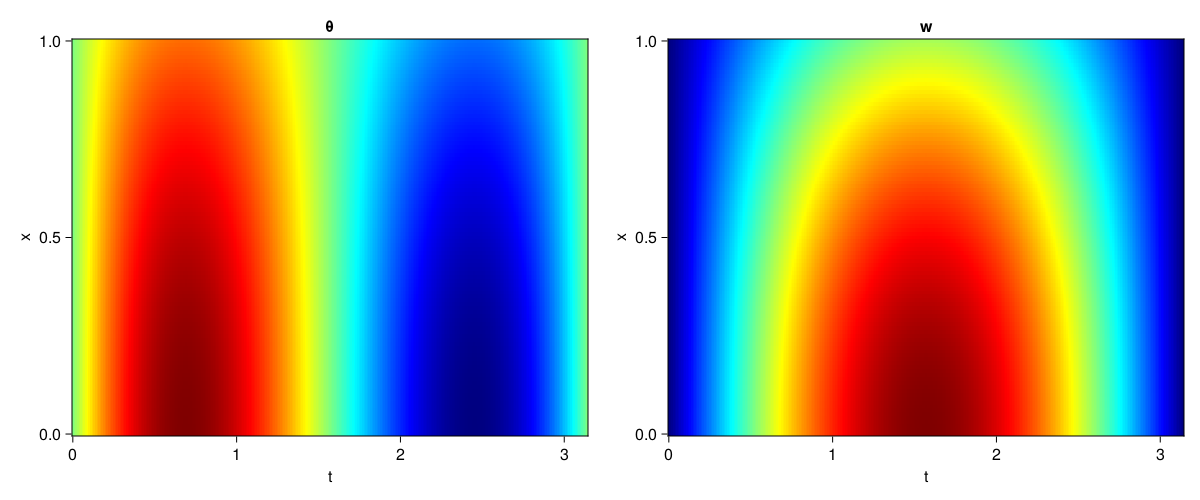

In [4]:
phi = pinn.phi
ps = res.u

xs, ts= [infimum(d.domain):0.01:supremum(d.domain) for d in timo.domain]

θ = [sum(phi.θ(([x,t]), ps.θ)) for x in xs, t in ts]
w = [sum(phi.w(([x,t]), ps.w)) for x in xs, t in ts]

fig = Figure(resolution=(1200,500))
axis = (xlabel="t", ylabel="x", title="θ")
heatmap(fig[1,1], xs, ts, θ, axis=axis, colormap=:jet)
heatmap(fig[1, 2], xs, ts, w, axis= merge(axis, (; title="w")), colormap=:jet)
display(fig)

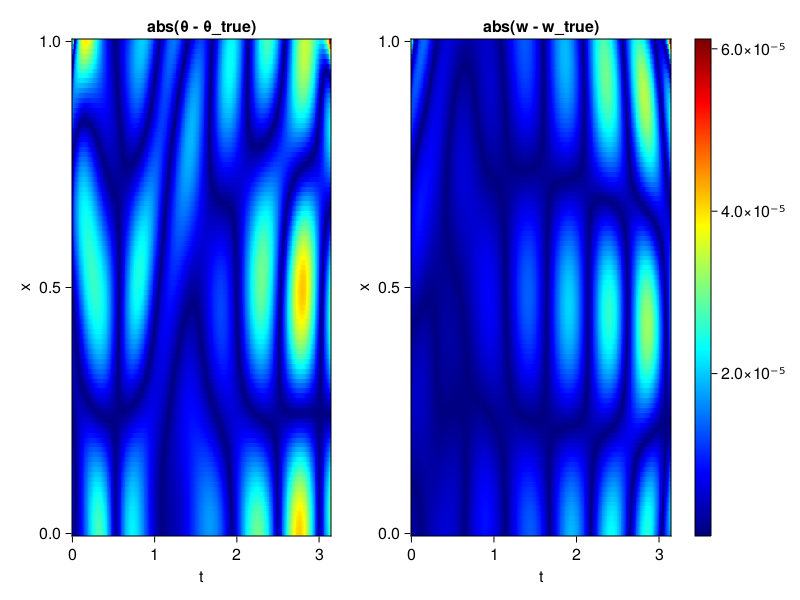

In [9]:
θ_analytic(x,t) = (π/2*cos(x) + x - π/2)*cos(t)
w_analytic(x,t) = π/2*sin(x)*cos(t)

θ_true = [θ_analytic(x,t) for x in xs, t in ts]
w_true = [w_analytic(x,t) for x in xs, t in ts]

axis = (xlabel="t", ylabel="x", title="abs(θ - θ_true)")
fig, ax1, hm1 = heatmap(xs, ts, abs.(θ .- θ_true), axis=axis, colormap=:jet)
ax2, hm2= heatmap(fig[1, 2], xs, ts, abs.(w .- w_true), axis= merge(axis, (; title="abs(w - w_true)")), colormap=:jet)
Colorbar(fig[:, end+1], hm2)
display(fig)